### Import Some Stuff

In [20]:
import os.path 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from statistics import pstdev
from scipy.fft import fftshift, ifft, fftfreq
import numpy as np
from scipy.signal.windows import tukey
import math
from scipy.interpolate import interp1d
from time import time as time
from time import strftime
from datetime import date
from scipy.signal import ShortTimeFFT
from scipy.signal import find_peaks, peak_widths
from scipy.stats import norm
from IPython.display import display, Latex
import re 
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.signal import hilbert
from matplotlib.patches import Rectangle
from scipy.signal import savgol_filter

import lmfit

from scipy.signal.windows import tukey

plt.rcParams.update({'font.size':16})

# SHG-FROG Temporal Width Recovery 

## El Functions

In [35]:
def gaussian(x, A, mu, sigma, offset):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset
def linear_func(x,m,c):
    return m*x +c

def quad_func(x,a,b,c):
    return a*x**2 + b*x +c 


def sech_squared(x,a,b,c):
    return a*(1/np.cosh(b*x))+c

def FROG_trace_folder(folder_path,save_folder_path, Relationship = None):

    temporal_widths_gauss =[]
    temporal_widths_sech =[]
    GDDs=[]
    
    folder = os.listdir(folder_path)
    

    for x in range(len(folder)):
        file_path = os.path.join(folder_path, folder[x])
        print('I am computing file',folder[x])
        #print(folder[x].split('_')[2])
        GDD = int(folder[x].split('_')[4])
        GDDs.append(GDD)
        #print(GDD)

        

       


        loaded_file = np.loadtxt(file_path)

        time = loaded_file[:,0]
        amplitude = loaded_file[:,1]


        analytic_signal = hilbert(amplitude)
        envelope = np.abs(analytic_signal)


        halfwidth =int(len(amplitude)/2)

        print(halfwidth)

        N = len(amplitude)
        center = N // 2
        

        start = center - int(halfwidth)
        end = center + int(halfwidth)
        signal_center = amplitude[start:end]
        envelope_center = envelope[start:end]
        time_center = time[start:end]


        peaks,peak_heights = find_peaks(signal_center,distance =10,prominence= 1e4)
        
        #print(len(peaks))

        A0= 2000*np.max(envelope_center)
        mu0 = time_center[np.argmax(envelope_center)]
        sigma0 = (time_center[-1] - time_center[0]) / 10
        offset0 = np.min(envelope_center)
        p0 = [A0, mu0, sigma0, offset0]
        

        params,params_covariance = curve_fit(gaussian, time_center[peaks], signal_center[peaks], p0=p0,maxfev =1000)
        params1,params_covariance1 = curve_fit(sech_squared, time_center[peaks], signal_center[peaks], p0=[A0,0.1,1])

        envelope_fit = (gaussian(time_center,(params[0]),params[1],params[2],params[3]))/np.max(gaussian(time_center,(params[0]),params[1],params[2],params[3]))
        envelope_fit_sech = (sech_squared(time_center,params1[0],params1[1],params1[2]))/np.max(sech_squared(time_center,params1[0],params1[1],params1[2]))
        time_fit = time_center[peaks]

        envelope_fit = envelope_fit - envelope_fit[0]
        envelope_fit_sech = envelope_fit_sech - envelope_fit_sech[0]


        fwhm = FWHM_2(time_center,envelope_fit)
        fwhm_2 = FWHM_2(time_center, envelope_fit_sech)

        #FROG_FWHM = fwhm/(np.sqrt(2))
        FROG_FWHM = fwhm/np.sqrt(2)
        #FROG_FWHM_2 = fwhm_2/(np.sqrt(2))
        FROG_FWHM_2 = fwhm_2/1.543
        temporal_widths_gauss.append(FROG_FWHM)
        temporal_widths_sech.append(FROG_FWHM_2)

        print('The estimated TL temporal width based on the above manipulation is {0:.3f}fs'.format(FROG_FWHM))

        plt.figure(figsize=(15,8))
        plt.plot(time, amplitude, color ='magenta', alpha = 0.8, label = 'SHG IAC 1d Trace')
        plt.plot(time_center,gaussian(time_center,(params[0]),params[1],params[2],params[3]), color='darkblue', label ='Gaussian Fit to SHG IAC peaks, Temp. Width ={0:.3f}fs'.format(FROG_FWHM))
        #plt.scatter(time_center[peaks], signal_center[peaks], color='red')
        plt.plot(time_center,sech_squared(time_center,params1[0],params1[1],params1[2]), color='darkorange', label ='$Sech^2$ Fit to SHG IAC peaks, Temp. Width ={0:.3f}fs'.format(FROG_FWHM_2))
        plt.xlabel("Time / fs")
        plt.ylabel("Arb. Intensity")
        plt.legend()
        title = 'SHG_IAC_trace_fit_GDD_'+str(GDD)+'.png'
        save_folder =os.path.join(save_folder_path,title)
        plt.title('SHG IAC Trace Fit for GDD='+str(GDD)+'$fs^2$')
        plt.savefig(save_folder)
        plt.show()

    if Relationship == True: 
    
        if len(GDDs) >1: 
            params, params_covariance = curve_fit(linear_func, GDDs, temporal_widths_gauss, p0=[1,0],maxfev =1000)
            #params1, params_covariance2 = curve_fit(quad_func,GDDs,temporal_widths_gauss, p0 =[1,0,0], maxfev= 1000)
            params2, params_covariance2 = curve_fit(linear_func, GDDs, temporal_widths_sech, p0=[1,0],maxfev =1000)

        #print(GDDs)
        GDDs =np.array(GDDs)

        plt.figure(figsize=(15,8))
        plt.scatter(GDDs, temporal_widths_gauss, color ='red', label = 'IAC Gaussian Fit Recovered Data Points')
        plt.scatter(GDDs, temporal_widths_sech, color ='blue', label = 'IAC $sech^2$ Fit Recovered Data Points')
        if len(GDDs) >1 :
            plt.plot(GDDs,linear_func(GDDs, params2[0], params2[1]), color ='blue', label = '$sech^2$ LOBF => y= {0:.3f}x + {1:.3f}'.format(params2[0],params2[1]))
            plt.plot(GDDs,linear_func(GDDs, params[0], params[1]), color ='red', label = 'Guassian LOBF => y= {0:.3f}x + {1:.3f}'.format(params[0],params[1]))
        #plt.plot(GDDs,quad_func(GDDs,*params1), color ='red', label ='Quadratic LOBF')
        plt.xlabel("Software Applied GDD ($fs^2$)")
        plt.ylabel("Temporal Width (fs)")
        plt.title("Time - Software GDD Relationship from SHG IAC Trace Recovered Data")
        title = 'Time_GDD_Relationship_GDD_recovered_'+(date.today()).strftime("_%d_%m_%y")+'.png'
        save_folder =os.path.join(save_folder_path,title)
        
        plt.savefig(save_folder)
        plt.legend()
        plt.show()

    text_title = 'Time_GDD_Relationship_GDD_recovered_'+(date.today()).strftime("_%d_%m_%y")+'.txt'
    save_name_2 =os.path.join(save_folder_path,text_title)

    #np.savetxt(save_name_2, np.c_[GDDs, temporal_widths_gauss, temporal_widths_sech],delimiter='\t')
    np.savetxt(save_name_2, np.c_[ temporal_widths_gauss, temporal_widths_sech],delimiter='\t')
    print(GDDs)
    print(GDDs)
    print('Gaussian', temporal_widths_gauss)
    print('sech',temporal_widths_sech)        

def FROG_trace(file, GDD):

    loaded_file = np.loadtxt(file)

    time = loaded_file[:,0]
    amplitude = loaded_file[:,1]


    analytic_signal = hilbert(amplitude)
    envelope = np.abs(analytic_signal)
    



    N = len(amplitude)
    center = N // 2
    halfwidth =int(len(amplitude)/2)

    start = center - int(0.9*halfwidth)
    end = center + int(0.9*halfwidth)
    signal_center = amplitude[start:end]
    envelope_center = envelope[start:end]
    time_center = time[start:end]

    peaks,peak_heights = find_peaks(signal_center,distance =10,prominence= 1e4)
        
    #print(len(peaks))

    A0= 2000*np.max(envelope_center)
    mu0 = time_center[np.argmax(envelope_center)]
    sigma0 = (time_center[-1] - time_center[0]) / 10
    offset0 = np.min(envelope_center)
    p0 = [A0, mu0, sigma0, offset0]
        

    params,params_covariance = curve_fit(gaussian, time_center[peaks], signal_center[peaks], p0=p0,maxfev =1000)
    params1,params_covariance1 = curve_fit(sech_squared, time_center[peaks], signal_center[peaks], p0=[A0,0.1,1])

    envelope_fit = (gaussian(time_center,(params[0]),params[1],params[2],params[3]))/np.max(gaussian(time_center,(params[0]),params[1],params[2],params[3]))
    envelope_fit_sech = (sech_squared(time_center,params1[0],params1[1],params1[2]))/np.max(sech_squared(time_center,params1[0],params1[1],params1[2]))
    time_fit = time_center[peaks]

    envelope_fit = envelope_fit - envelope_fit[0]
    envelope_fit_sech = envelope_fit_sech - envelope_fit_sech[0]


    fwhm = FWHM_2(time_center,envelope_fit)
    fwhm_2 = FWHM_2(time_center, envelope_fit_sech)

    #FROG_FWHM = fwhm/(np.sqrt(2))
    FROG_FWHM = fwhm*0.648
    #FROG_FWHM_2 = fwhm_2/(np.sqrt(2))
    FROG_FWHM_2 = fwhm_2*0.648
  

    print('The estimated TL temporal width based on the above manipulation is {0:.3f}fs'.format(FROG_FWHM))

    plt.figure(figsize=(15,8))
    plt.plot(time, amplitude, color ='magenta', label = 'SHG IAC Trace')
    #plt.scatter(time_center[peaks], signal_center[peaks], color='red')
    #plt.plot(time_center,gaussian(time_center,(params[0]),params[1],params[2],params[3]), color='darkblue', label ='Gaussian Fit to IAC peaks, Temp. Width ={0:.3f}fs'.format(FROG_FWHM))
    plt.plot(time_center,sech_squared(time_center,params1[0],params1[1],params1[2]), color='darkorange', label ='$Sech^2$ Fit to IAC peaks, Temp. Width ={0:.3f}fs'.format(FROG_FWHM_2))
    plt.xlabel("Time \ fs ")
    plt.ylabel(" Intensity \ Arb. Units")
    plt.legend()
    plt.xlim(-250,250)
    title = 'SHG_IAC_trace_fit_GDD_'+str(GDD)+'.png'
    plt.title('SHG IAC trace fit, GDD = '+str(GDD)+'$fs^2$')
    plt.savefig(title)
    plt.show()
    
    
    return FROG_FWHM

def FWHM_2(x,y):
    peak =np.argmax(y)
    peak_val =y[peak]
    half_max = peak_val /2 
    

    # Left side
    left_region = y[:peak]
    if np.any(left_region <= half_max):
        y1 = np.where(left_region <= half_max)[0][-1]
        y0 = y1 + 1
        # linear interpolation for crossing
        x_left = x[y1] + (x[y0] - x[y1]) * (half_max - y[y1]) / (y[y0] - y[y1])
    #else:
        #return np.nan
    
    # Right side
    right_region = y[peak:]
    if np.any(right_region <= half_max):
        y1 = np.where(right_region <= half_max)[0][0] + peak
        y0 = y1 - 1
        x_right = x[y1] + (x[y0] - x[y1]) * (half_max - y[y1]) / (y[y0] - y[y1])
    #else:
        #return np.nan
    
    fwhm = x_right -x_left
    return fwhm


<>:207: SyntaxWarning: invalid escape sequence '\ '
<>:208: SyntaxWarning: invalid escape sequence '\ '
<>:207: SyntaxWarning: invalid escape sequence '\ '
<>:208: SyntaxWarning: invalid escape sequence '\ '
/var/folders/ch/jpgfqsp91mq7dcm3hcx5l0vc0000gn/T/ipykernel_1838/2276820300.py:207: SyntaxWarning: invalid escape sequence '\ '
  plt.xlabel("Time \ fs ")
/var/folders/ch/jpgfqsp91mq7dcm3hcx5l0vc0000gn/T/ipykernel_1838/2276820300.py:208: SyntaxWarning: invalid escape sequence '\ '
  plt.ylabel(" Intensity \ Arb. Units")


## Load The Data File

In [3]:
file_path = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/201125 Attempt/test/201125_gdd_33_FROG_801_100_1d.txt'
applied_GDD = 33
save_name = 'an_attempt_at_a_fit_GDD_'+str(applied_GDD)+'.txt'

## Apply The Function

In [16]:
#FWHM_time = FROG_trace(file_path, applied_GDD)

## Load the Data Folder 

In [5]:
folder = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/211125/1D_FROG/'
save_folder_path = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/Results/211125/'



## Apply the Folder Function 

In [34]:
'''
file_4484 = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/251125_GDD_4484_6001_1_1d.txt'
loaded_file_4484 = np.loadtxt(file_4484)

time_4484 = loaded_file_4484[:,0]
amplitude_4484 = loaded_file_4484[:,1]

start = 1000
end =5001
amplitude_4484_crop = amplitude_4484[start:end]
print(len(amplitude_4484_crop))
time_4484_crop = time_4484[start:end]
'''

"\nfile_4484 = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/251125_GDD_4484_6001_1_1d.txt'\nloaded_file_4484 = np.loadtxt(file_4484)\n\ntime_4484 = loaded_file_4484[:,0]\namplitude_4484 = loaded_file_4484[:,1]\n\nstart = 1000\nend =5001\namplitude_4484_crop = amplitude_4484[start:end]\nprint(len(amplitude_4484_crop))\ntime_4484_crop = time_4484[start:end]\n"

In [35]:
'''
plt.figure(figsize=(15,8))
plt.plot(time_4484, amplitude_4484, color ='red', label = 'FROG Recovered Data Points')
plt.plot(time_4484_crop, amplitude_4484_crop, color ='blue', label = 'FROG Recovered Data Points')
plt.xlabel("Software Applied GDD ($fs^2$)")
plt.ylabel("Temporal Width (fs)")
plt.title("Time - Software GDD Relationship from FROG Trace Recovered Data")
title = 'Time_GDD_Relationship_GDD_recovered_'+(date.today()).strftime("_%d_%m_%y")+'.png'
#save_folder =os.path.join(save_folder_path,title)

#plt.savefig(save_folder)
plt.legend()
plt.show()

'''

'\nplt.figure(figsize=(15,8))\nplt.plot(time_4484, amplitude_4484, color =\'red\', label = \'FROG Recovered Data Points\')\nplt.plot(time_4484_crop, amplitude_4484_crop, color =\'blue\', label = \'FROG Recovered Data Points\')\nplt.xlabel("Software Applied GDD ($fs^2$)")\nplt.ylabel("Temporal Width (fs)")\nplt.title("Time - Software GDD Relationship from FROG Trace Recovered Data")\ntitle = \'Time_GDD_Relationship_GDD_recovered_\'+(date.today()).strftime("_%d_%m_%y")+\'.png\'\n#save_folder =os.path.join(save_folder_path,title)\n\n#plt.savefig(save_folder)\nplt.legend()\nplt.show()\n\n'

In [36]:
#np.savetxt('251125_GDD_4484_cropped.txt', np.c_[time_4484_crop, amplitude_4484_crop],delimiter='\t')

In [37]:
'''
file_3321 = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/251125_GDD_3321_6001_1_1d.txt'
loaded_file_3321 = np.loadtxt(file_3321)

time_3321 = loaded_file_3321[:,0]
amplitude_3321 = loaded_file_3321[:,1]

start = 1900
end =4501
amplitude_3321_crop = amplitude_3321[start:end]
print(len(amplitude_3321_crop))
time_3321_crop = time_3321[start:end]
'''

"\nfile_3321 = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/251125_GDD_3321_6001_1_1d.txt'\nloaded_file_3321 = np.loadtxt(file_3321)\n\ntime_3321 = loaded_file_3321[:,0]\namplitude_3321 = loaded_file_3321[:,1]\n\nstart = 1900\nend =4501\namplitude_3321_crop = amplitude_3321[start:end]\nprint(len(amplitude_3321_crop))\ntime_3321_crop = time_3321[start:end]\n"

In [38]:
'''
plt.figure(figsize=(15,8))
plt.plot(time_3321, amplitude_3321, color ='red', label = 'FROG Recovered Data Points')
plt.plot(time_3321_crop, amplitude_3321_crop, color ='blue', label = 'FROG Recovered Data Points')
plt.xlabel("Software Applied GDD ($fs^2$)")
plt.ylabel("Temporal Width (fs)")
plt.title("Time - Software GDD Relationship from FROG Trace Recovered Data")
title = 'Time_GDD_Relationship_GDD_recovered_'+(date.today()).strftime("_%d_%m_%y")+'.png'
#save_folder =os.path.join(save_folder_path,title)

#plt.savefig(save_folder)
plt.legend()
plt.show()
'''

'\nplt.figure(figsize=(15,8))\nplt.plot(time_3321, amplitude_3321, color =\'red\', label = \'FROG Recovered Data Points\')\nplt.plot(time_3321_crop, amplitude_3321_crop, color =\'blue\', label = \'FROG Recovered Data Points\')\nplt.xlabel("Software Applied GDD ($fs^2$)")\nplt.ylabel("Temporal Width (fs)")\nplt.title("Time - Software GDD Relationship from FROG Trace Recovered Data")\ntitle = \'Time_GDD_Relationship_GDD_recovered_\'+(date.today()).strftime("_%d_%m_%y")+\'.png\'\n#save_folder =os.path.join(save_folder_path,title)\n\n#plt.savefig(save_folder)\nplt.legend()\nplt.show()\n'

In [39]:
#np.savetxt('251125_GDD_3321_cropped.txt', np.c_[time_3321_crop, amplitude_3321_crop],delimiter='\t')

In [40]:
'''
file_700 = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/251125_GDD_700_3001_1_1d.txt'
loaded_file_700 = np.loadtxt(file_700)

time_700 = loaded_file_700[:,0]
amplitude_700 = loaded_file_700[:,1]

start = 1100
end =1800
amplitude_700_crop = amplitude_700[start:end]
print(len(amplitude_700_crop))
time_700_crop = time_700[start:end]
'''

"\nfile_700 = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/251125_GDD_700_3001_1_1d.txt'\nloaded_file_700 = np.loadtxt(file_700)\n\ntime_700 = loaded_file_700[:,0]\namplitude_700 = loaded_file_700[:,1]\n\nstart = 1100\nend =1800\namplitude_700_crop = amplitude_700[start:end]\nprint(len(amplitude_700_crop))\ntime_700_crop = time_700[start:end]\n"

In [41]:
'''
plt.figure(figsize=(15,8))
plt.plot(time_700, amplitude_700, color ='red', label = 'FROG Recovered Data Points')
plt.plot(time_700_crop, amplitude_700_crop, color ='blue', label = 'FROG Recovered Data Points')
plt.xlabel("Software Applied GDD ($fs^2$)")
plt.ylabel("Temporal Width (fs)")
plt.title("Time - Software GDD Relationship from FROG Trace Recovered Data")
title = 'Time_GDD_Relationship_GDD_recovered_'+(date.today()).strftime("_%d_%m_%y")+'.png'
#save_folder =os.path.join(save_folder_path,title)

#plt.savefig(save_folder)
plt.legend()
plt.show()
'''

'\nplt.figure(figsize=(15,8))\nplt.plot(time_700, amplitude_700, color =\'red\', label = \'FROG Recovered Data Points\')\nplt.plot(time_700_crop, amplitude_700_crop, color =\'blue\', label = \'FROG Recovered Data Points\')\nplt.xlabel("Software Applied GDD ($fs^2$)")\nplt.ylabel("Temporal Width (fs)")\nplt.title("Time - Software GDD Relationship from FROG Trace Recovered Data")\ntitle = \'Time_GDD_Relationship_GDD_recovered_\'+(date.today()).strftime("_%d_%m_%y")+\'.png\'\n#save_folder =os.path.join(save_folder_path,title)\n\n#plt.savefig(save_folder)\nplt.legend()\nplt.show()\n'

In [42]:
#np.savetxt('251125_GDD_700_cropped.txt', np.c_[time_700_crop, amplitude_700_crop],delimiter='\t')

## Attempt 2 

901


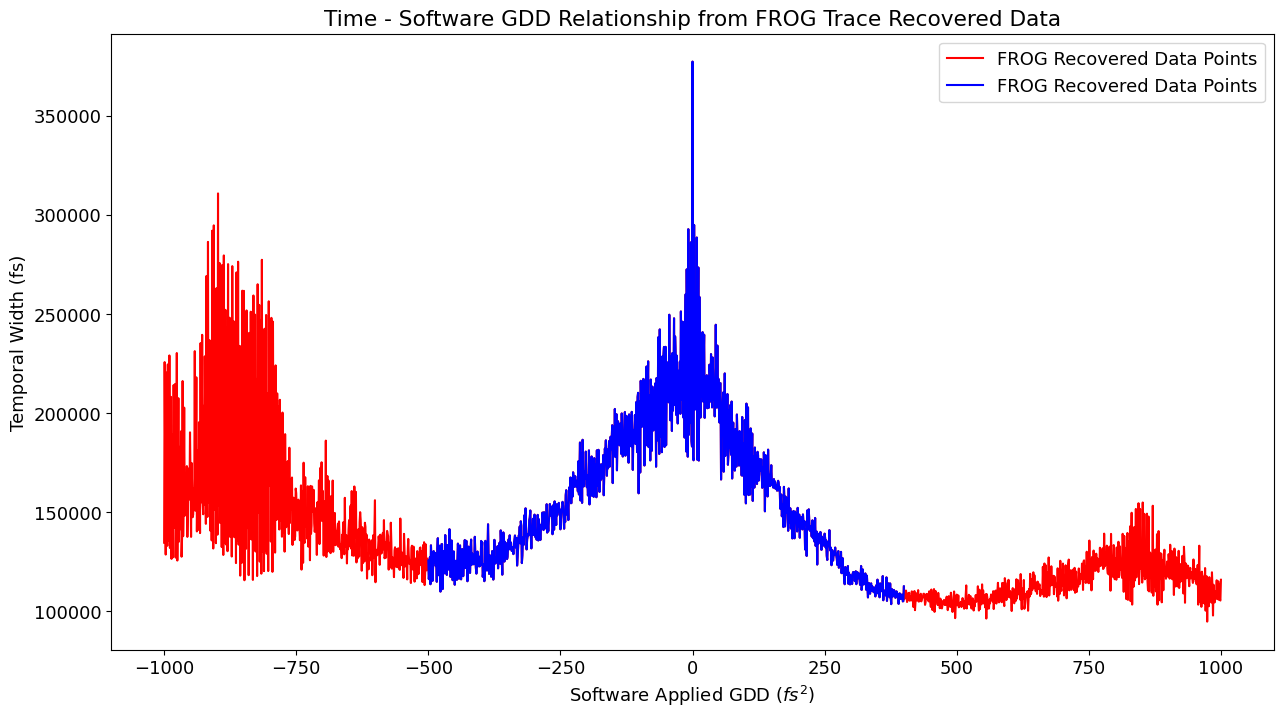

In [66]:
file_750 = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/Results/Autocorrelation Output Masks 021225/021225_GDD_1000_2001_1_1d.txt'
loaded_file_750 = np.loadtxt(file_750)

time_750 = loaded_file_750[:,0]
amplitude_750 = loaded_file_750[:,1]

start = 500
end =1401
amplitude_750_crop = amplitude_750[start:end]
print(len(amplitude_750_crop))
time_750_crop = time_750[start:end]

plt.figure(figsize=(15,8))
plt.plot(time_750, amplitude_750, color ='red', label = 'FROG Recovered Data Points')
plt.plot(time_750_crop, amplitude_750_crop, color ='blue', label = 'FROG Recovered Data Points')
plt.xlabel("Software Applied GDD ($fs^2$)")
plt.ylabel("Temporal Width (fs)")
plt.title("Time - Software GDD Relationship from FROG Trace Recovered Data")
title = 'Time_GDD_Relationship_GDD_recovered_'+(date.today()).strftime("_%d_%m_%y")+'.png'
#save_folder =os.path.join(save_folder_path,title)

#plt.savefig(save_folder)
plt.legend()
plt.show()


new_title = '021225_GDD_1000_2001_1_cropped.txt'
save_name_3 =os.path.join(folder_2,new_title)


np.savetxt(save_name_3, np.c_[time_750_crop, amplitude_750_crop],delimiter='\t')


In [14]:
#folder_2= r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/Results/Autocorrelation Output Masks 021225/proper_files/'
#save_folder_path_2 = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/Results/SHG IAC Trace/'


#FROG_trace_folder(folder_2,save_folder_path_2, Relationship= True)

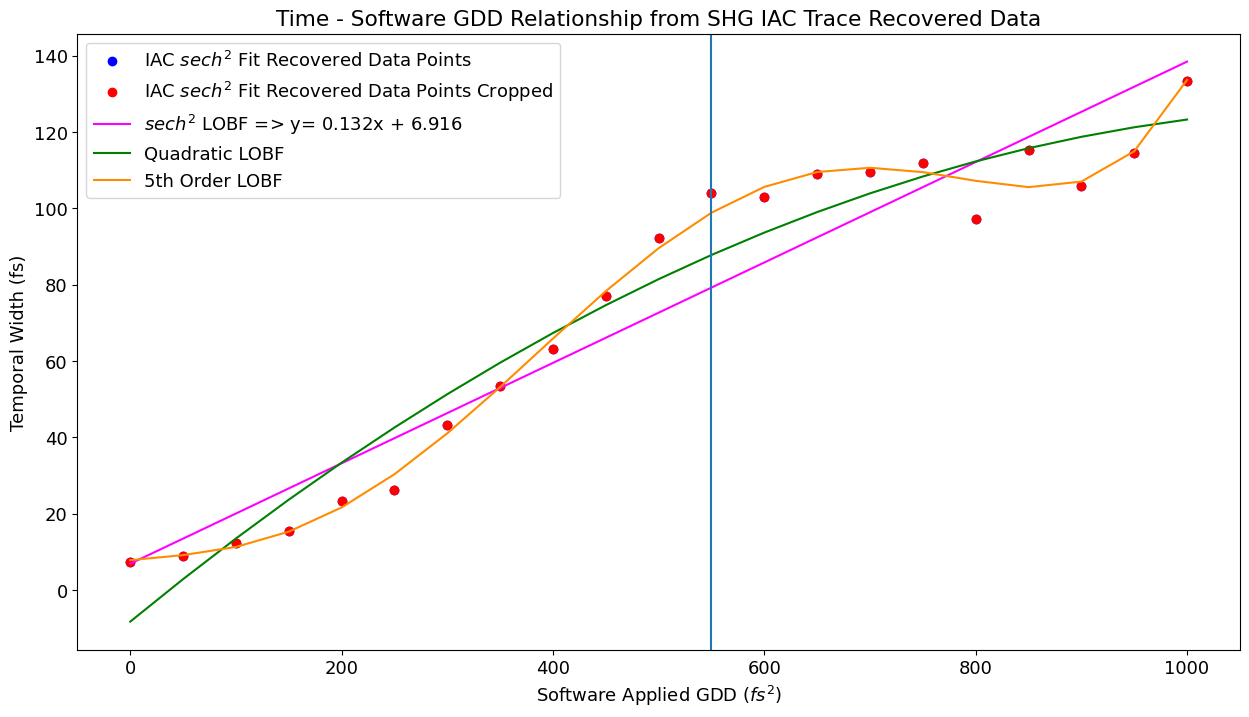

In [142]:

#gdd =np.array([330,700,3321,4484])
gdd = np.array([330,700])

#sech_fwhm =[56.483,100.416,688.5,1080]
sech_fwhm =[56.483,100.416]

file_from_above =r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/Results/SHG IAC Trace/Time_GDD_Relationship_GDD_recovered__02_12_25.txt'
loaded = np.loadtxt(file_from_above)

GDDs = loaded[:,0]
temporal_widths_gauss = loaded[:,1]
temporal_widths_sech = loaded[:,2]

temporal_widths_sech = np.hstack((7.463,temporal_widths_sech))
GDDs = np.hstack((0,GDDs))

start = 0
end = 21

idx = np.argsort(GDDs)
GDDs = GDDs[idx]
temporal_widths_sech =temporal_widths_sech[idx]


GDDs_crop = GDDs[start:end]
temporal_widths_sech_crop = temporal_widths_sech[start:end]

def sech_fit(x,t_0,c):
    return t_0*np.sqrt(1+((c*x)/(t_0)**2)**2)

def fith_poly(x,a,b,c,d,e,f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x +f 

params, params_covariance = curve_fit(linear_func, GDDs_crop, temporal_widths_sech_crop, p0=[1,0],maxfev =1000)
params2,params_covariance_2 = curve_fit(quad_func,GDDs_crop, temporal_widths_sech_crop, p0=[1,0,0])
params3,params_covariance_3 = curve_fit(fith_poly,GDDs_crop, temporal_widths_sech_crop, p0=[1,0,0,0,0,0])
params4,params_covariance_4 = curve_fit(sech_fit,GDDs_crop, temporal_widths_sech_crop, p0=[1,0])

plt.figure(figsize=(15,8))
#plt.scatter(GDDs, temporal_widths_gauss, color ='red', label = 'IAC Gaussian Fit Recovered Data Points')
plt.scatter(GDDs, temporal_widths_sech, color ='blue', label = 'IAC $sech^2$ Fit Recovered Data Points')
plt.scatter(GDDs_crop, temporal_widths_sech_crop, color ='red', label = 'IAC $sech^2$ Fit Recovered Data Points Cropped')

plt.plot(GDDs_crop,linear_func(GDDs_crop, params[0], params[1]), color ='magenta', label = '$sech^2$ LOBF => y= {0:.3f}x + {1:.3f}'.format(params[0],params[1]))
plt.plot(GDDs_crop,quad_func(GDDs_crop,*params2), color ='green', label ='Quadratic LOBF')
plt.plot(GDDs_crop,fith_poly(GDDs_crop,*params3), color ='darkorange', label ='5th Order LOBF')
#plt.plot(GDDs_crop,sech_fit(GDDs_crop,temporal_widths_sech[0],0.315), color ='darkblue', label ='Sech Perfect Fit')
plt.xlabel("Software Applied GDD ($fs^2$)")
plt.ylabel("Temporal Width (fs)")
plt.axvline(550)
plt.title("Time - Software GDD Relationship from SHG IAC Trace Recovered Data")
title = 'Time_GDD_Relationship_GDD_recovered_'+(date.today()).strftime("_%d_%m_%y")+'.png'
save_folder =os.path.join(save_folder_path,title)

#plt.savefig(save_folder)
plt.legend()
plt.show()

In [15]:
#day_two_folder =r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/031225/Autocorrelation Results 2/1d/'
#day_two_save = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/Results/031225'


#FROG_trace_folder(day_two_folder,day_two_save, Relationship= True)

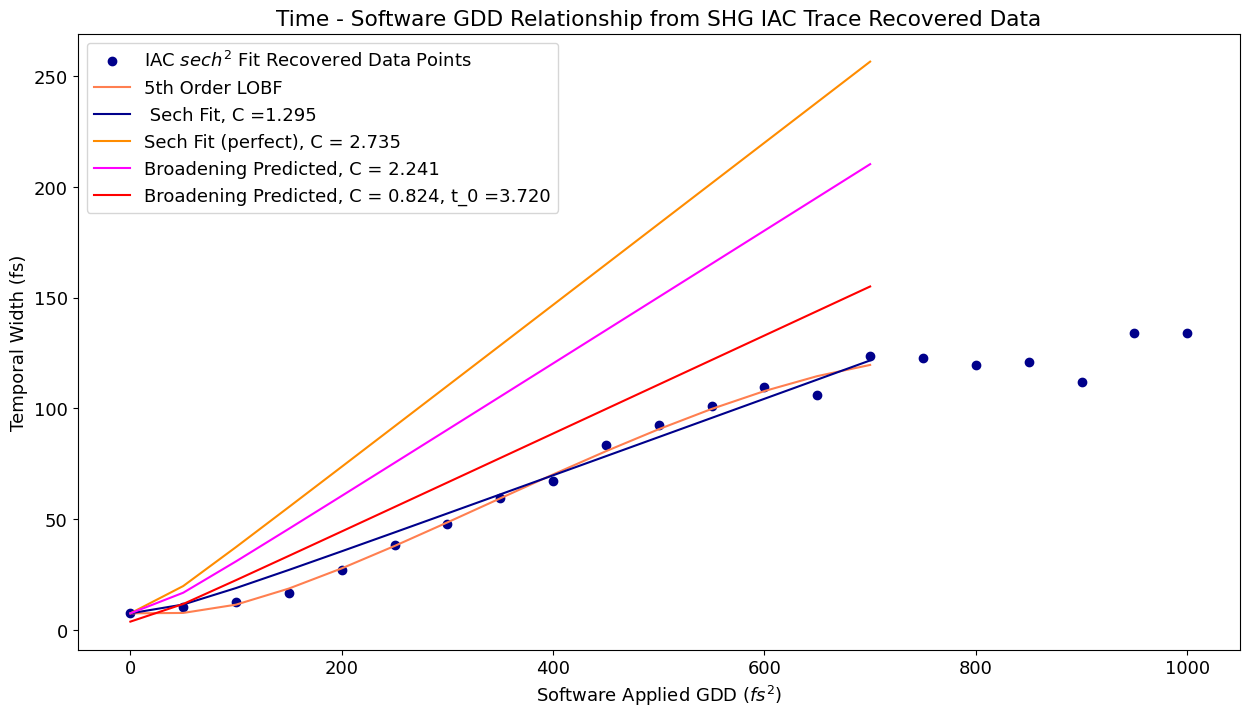

In [204]:
file_from_above_2 =r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/Results/031225/Time_GDD_Relationship_GDD_recovered__03_12_25.txt'
loaded = np.loadtxt(file_from_above_2)

GDDs = loaded[:,0]
temporal_widths_gauss = loaded[:,1]
temporal_widths_sech = loaded[:,2]

temporal_widths_sech = np.hstack((7.463,temporal_widths_sech))
temporal_widths_gauss = np.hstack((7.463,temporal_widths_gauss))
GDDs = np.hstack((0,GDDs))

start = 0
end = 15

idx = np.argsort(GDDs)
GDDs = GDDs[idx]
temporal_widths_sech =temporal_widths_sech[idx]
temporal_widths_gauss =temporal_widths_gauss[idx]


GDDs_crop = GDDs[start:end]
temporal_widths_sech_crop = temporal_widths_sech[start:end]
temporal_widths_gauss_crop = temporal_widths_gauss[start:end]

def sech_fit(x,c):
    return 7.463*np.sqrt(1+((c*x)/(7.463)**2)**2)

def sech_2(x,t_0,c):
    return t_0*np.sqrt(1+((c*x)/(t_0)**2)**2)


def fith_poly(x,a,b,c,d):
    return 7.463*np.sqrt(1+a*(x**2) + b*(x**3) + c*(x**4) + d*(x**5) )

params, params_covariance = curve_fit(linear_func, GDDs_crop, temporal_widths_sech_crop, p0=[1,0],maxfev =1000)
params2,params_covariance_2 = curve_fit(quad_func,GDDs_crop, temporal_widths_sech_crop, p0=[1,0,0])
params3,params_covariance_3 = curve_fit(fith_poly,GDDs_crop, temporal_widths_sech_crop, p0=[1e-7,1e-9,1e-11,1e-13], maxfev =1000)
params4,params_covariance_4 = curve_fit(sech_fit,GDDs_crop, temporal_widths_sech_crop, p0=[1.5])
params5,params_covariance_5 = curve_fit(sech_fit,GDDs_crop, temporal_widths_gauss_crop, p0=[1.5])
params6,params_covariance_6= curve_fit(sech_2,GDDs_crop, temporal_widths_gauss_crop, p0=[1.5,0])

plt.figure(figsize=(15,8))
#plt.scatter(GDDs, temporal_widths_gauss, color ='red', label = 'IAC Gaussian Fit Recovered Data Points')
plt.scatter(GDDs, temporal_widths_sech, color ='darkblue', label = 'IAC $sech^2$ Fit Recovered Data Points')
#plt.scatter(GDDs_crop, temporal_widths_sech_crop, color ='orange', label = 'IAC $sech^2$ Fit Recovered Data Points Cropped')

#plt.plot(GDDs_crop,linear_func(GDDs_crop, params[0], params[1]), color ='magenta', label = '$sech^2$ LOBF => y= {0:.3f}x + {1:.3f}'.format(params[0],params[1]))
#plt.plot(GDDs_crop,quad_func(GDDs_crop,*params2), color ='green', label ='Quadratic LOBF')
plt.plot(GDDs_crop,fith_poly(GDDs_crop,*params3), color ='coral', label ='5th Order LOBF')
plt.plot(GDDs_crop,sech_fit(GDDs_crop,params4[0]), color ='darkblue', label =' Sech Fit, C ={0:.3f}'.format(params4[0]))
#plt.plot(GDDs_crop,sech_fit(GDDs_crop,params5[0]), color ='red', label ='Guassian Fit, C ={0:.3f}'.format(params5[0]))
plt.plot(GDDs_crop,sech_fit(GDDs_crop,2.735), color ='darkorange', label ='Sech Fit (perfect), C = 2.735')
plt.plot(GDDs_crop,sech_fit(GDDs_crop,2.241), color ='magenta', label ='Broadening Predicted, C = 2.241')
plt.plot(GDDs_crop,sech_2(GDDs_crop,params6[0],params6[1]), color ='red', label ='Broadening Predicted, C = {0:.3f}, t_0 ={1:.3f}'.format(params6[1],params6[0]))
#plt.plot(GDDs_crop,sech_fit(GDDs_crop,(4*np.log(2))), color ='green', label ='Gaussian Fit (perfect), C = 4ln(2))')
plt.xlabel("Software Applied GDD ($fs^2$)")
plt.ylabel("Temporal Width (fs)")
#plt.axvline(550)
#plt.ylim(-10,100)
plt.title("Time - Software GDD Relationship from SHG IAC Trace Recovered Data")
title = 'Time_GDD_Relationship_GDD_recovered_'+(date.today()).strftime("_%d_%m_%y")+'.png'
save_folder =os.path.join(save_folder_path,title)

#plt.savefig(save_folder)
plt.legend()
plt.show()

Performing this fit for C is most likely and invalid model. This is given the fact that we do not have a monotonic pulse and even though we are only applying GDD there might still be effects of the compensation mask correcting for TOD that means this is very much not valid. 

I am computing file 081225_GDD_450_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 108.282fs


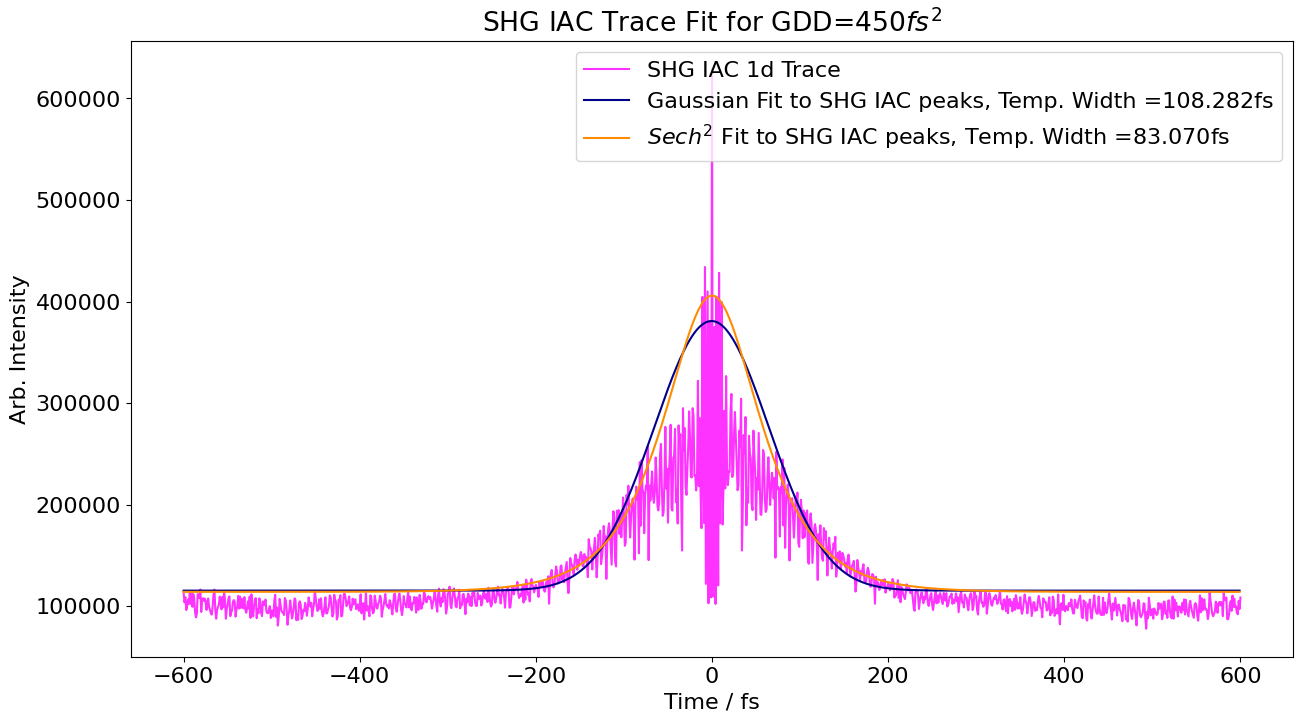

I am computing file 081225_GDD_500_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 116.458fs


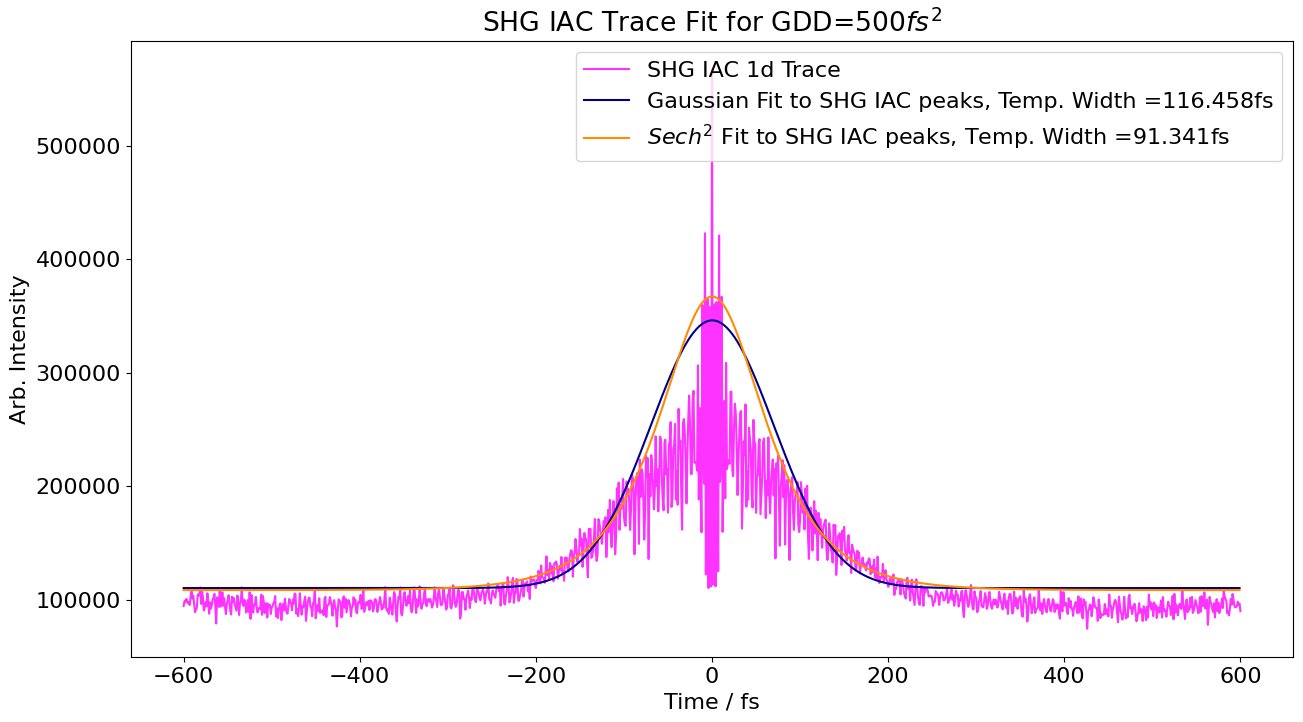

I am computing file 081225_GDD_350_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 82.228fs


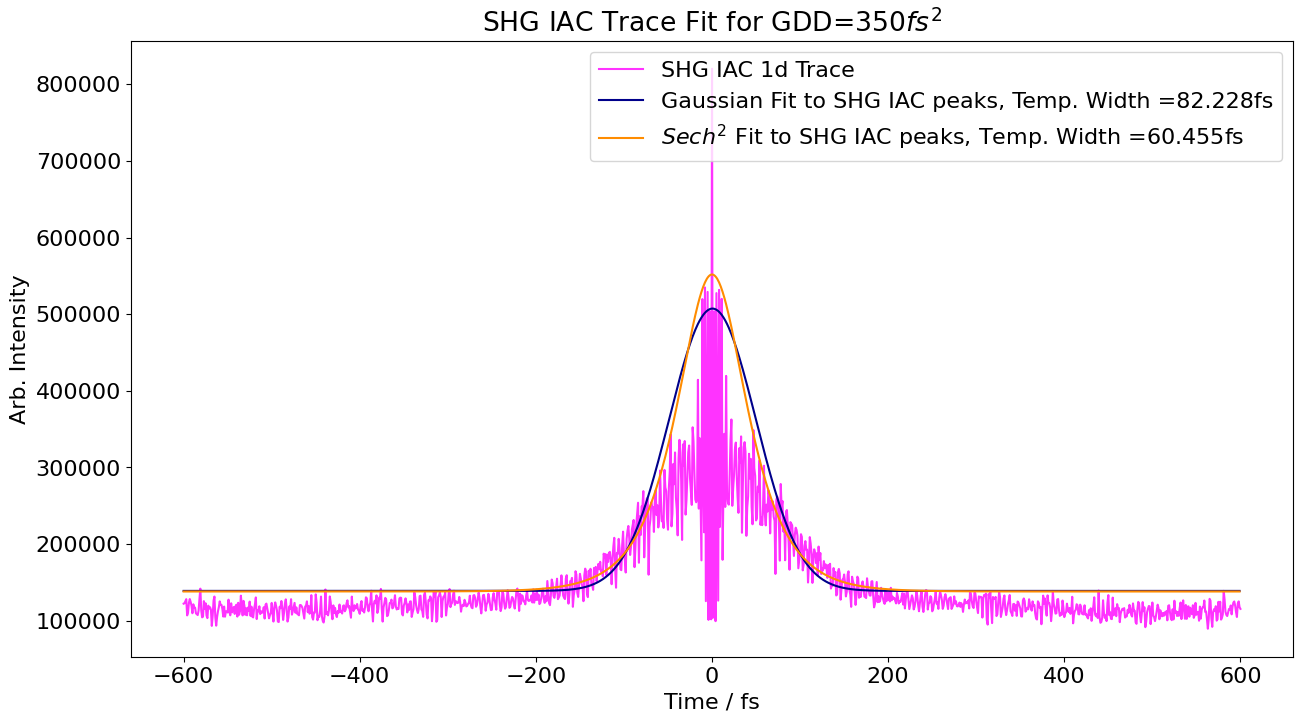

I am computing file 081225_GDD_200_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 29.311fs


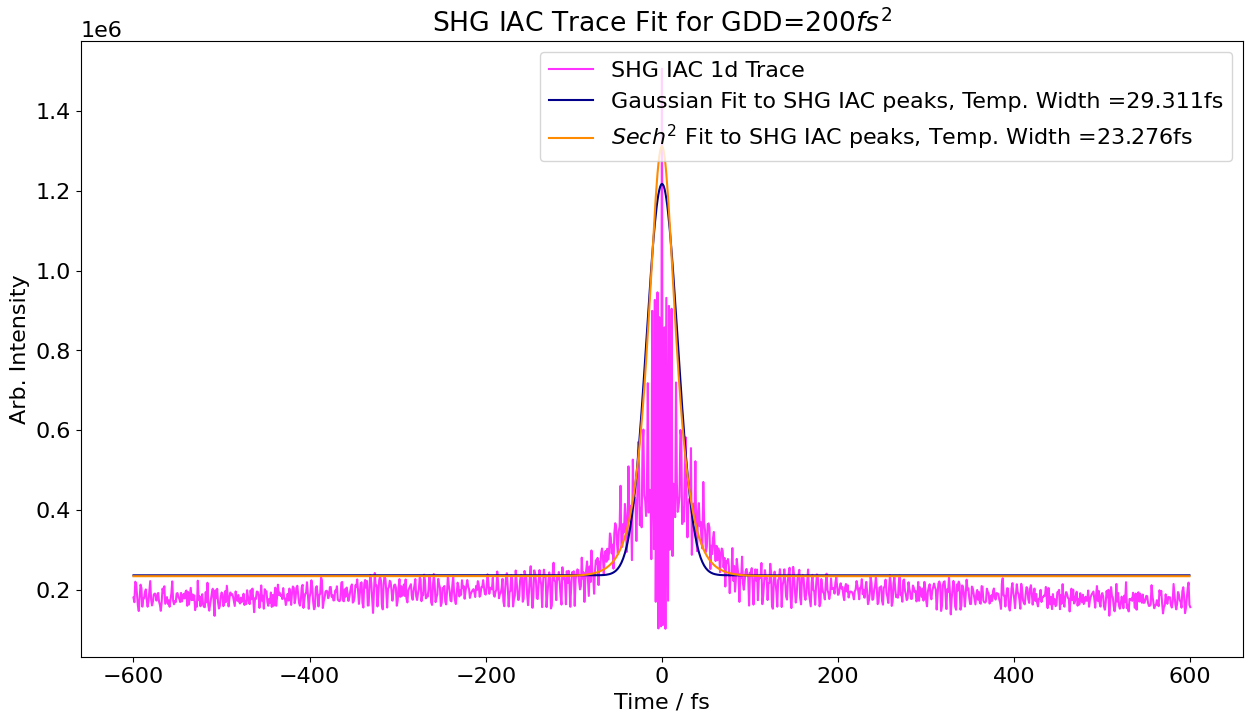

I am computing file 081225_GDD_250_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 41.516fs


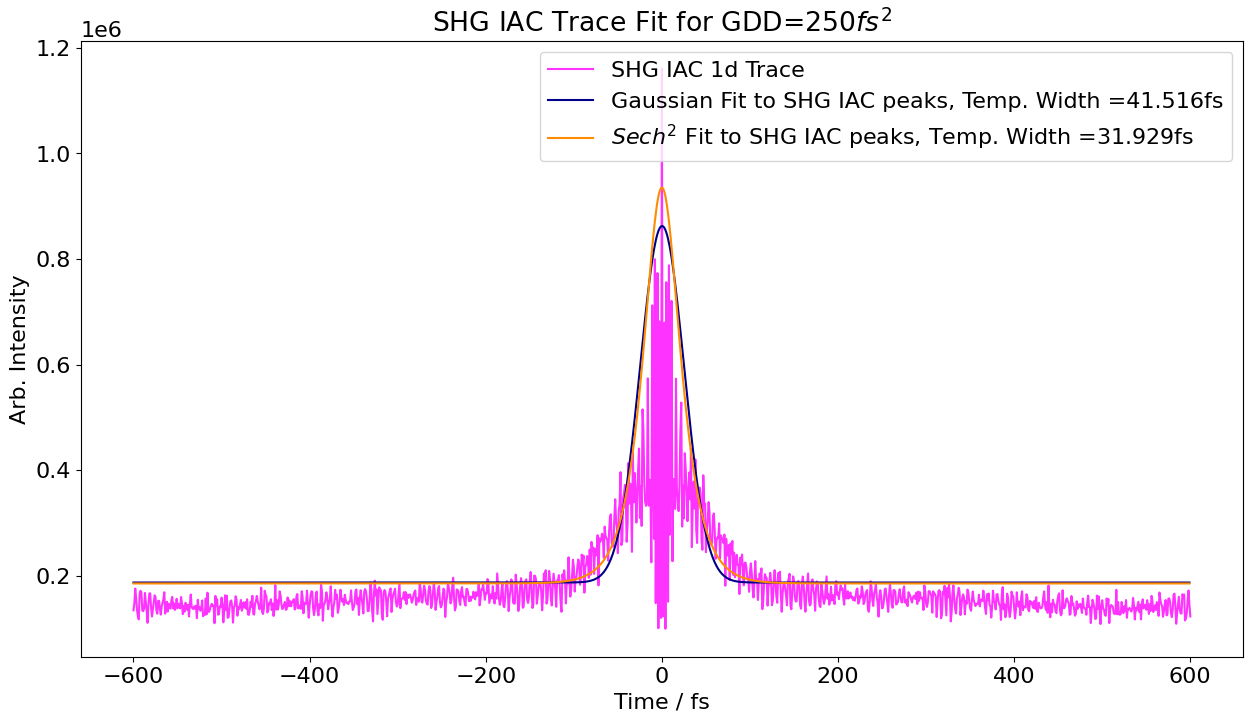

I am computing file 081225_GDD_300_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 69.534fs


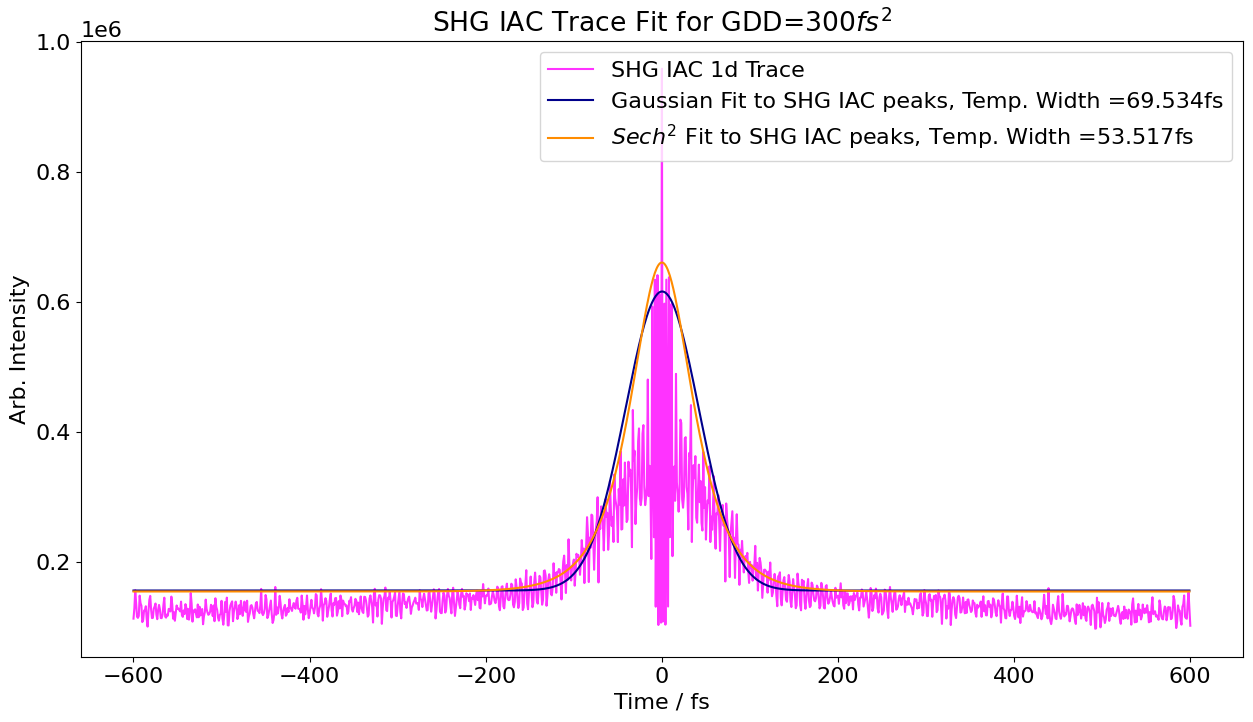

I am computing file 081225_GDD_550_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 126.147fs


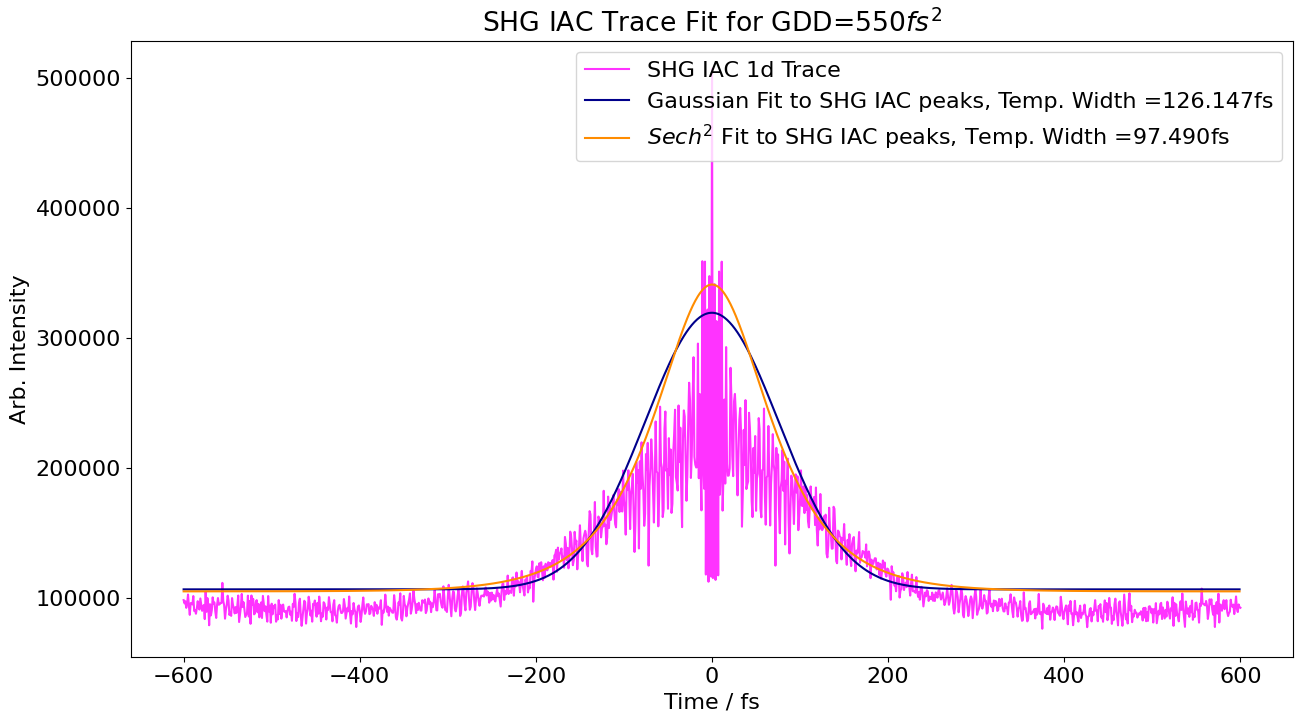

I am computing file 081225_GDD_400_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 92.029fs


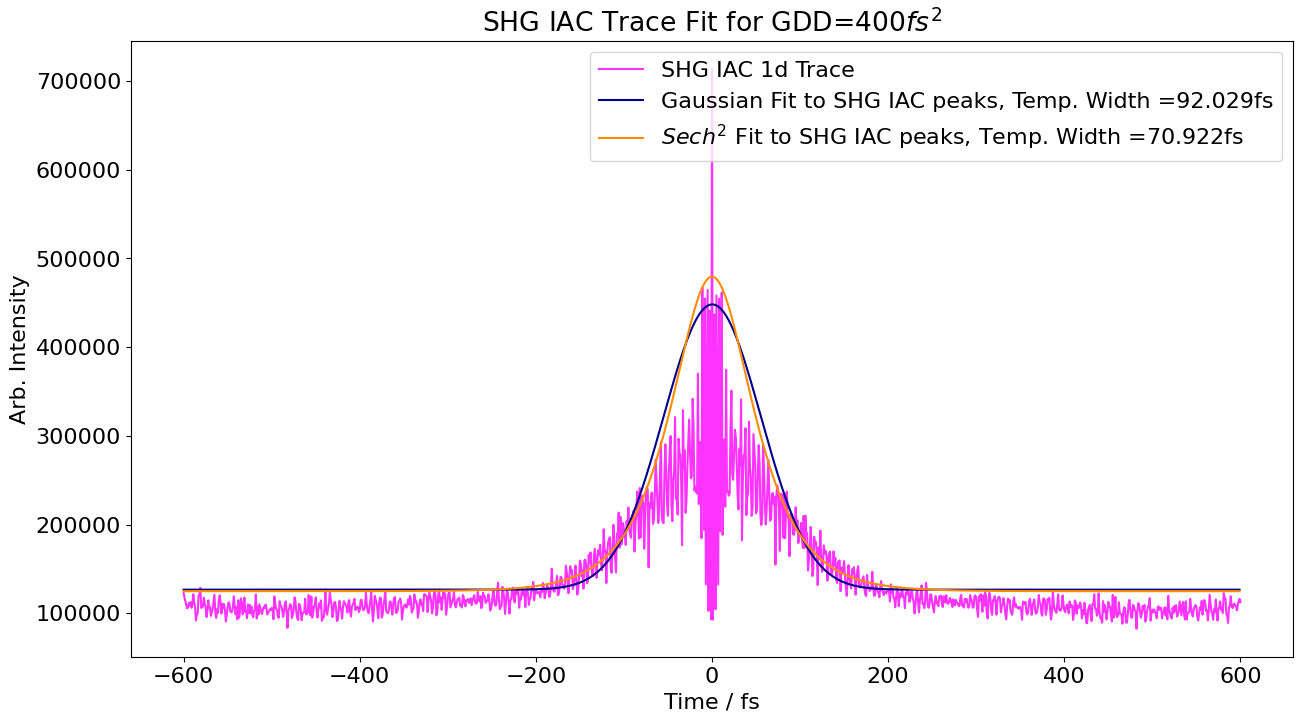

I am computing file 081225_GDD_50_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 10.813fs


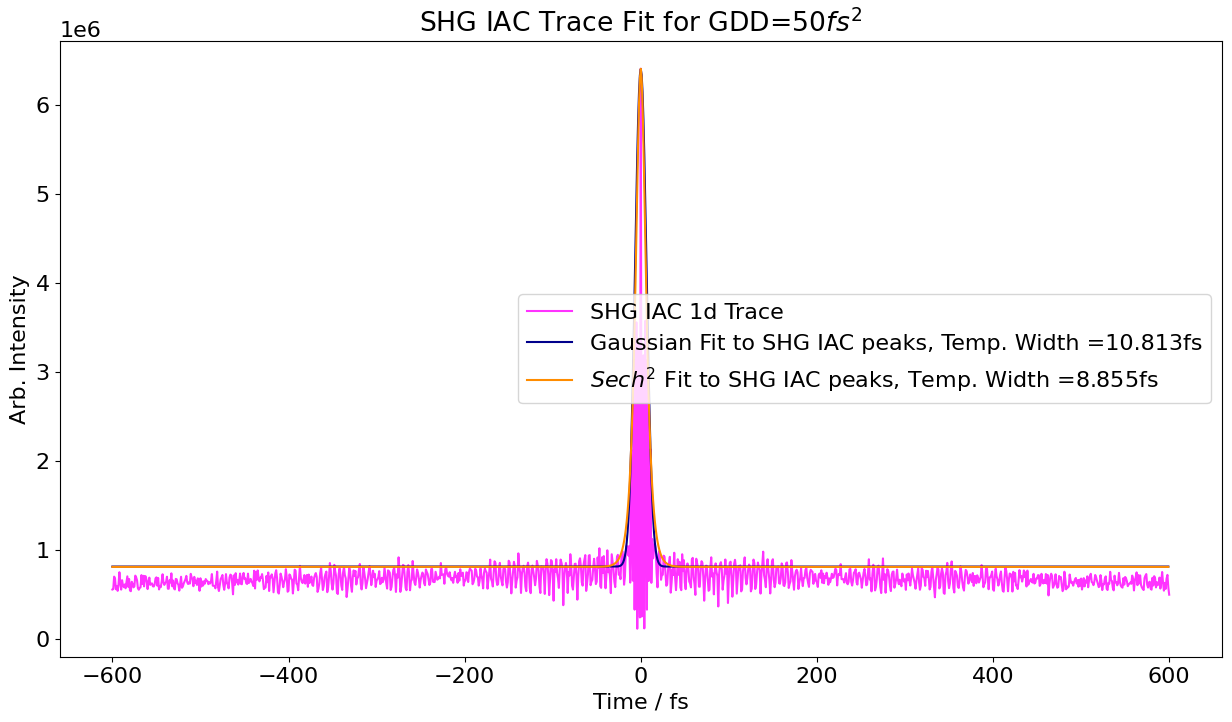

I am computing file 081225_GDD_100_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 15.120fs


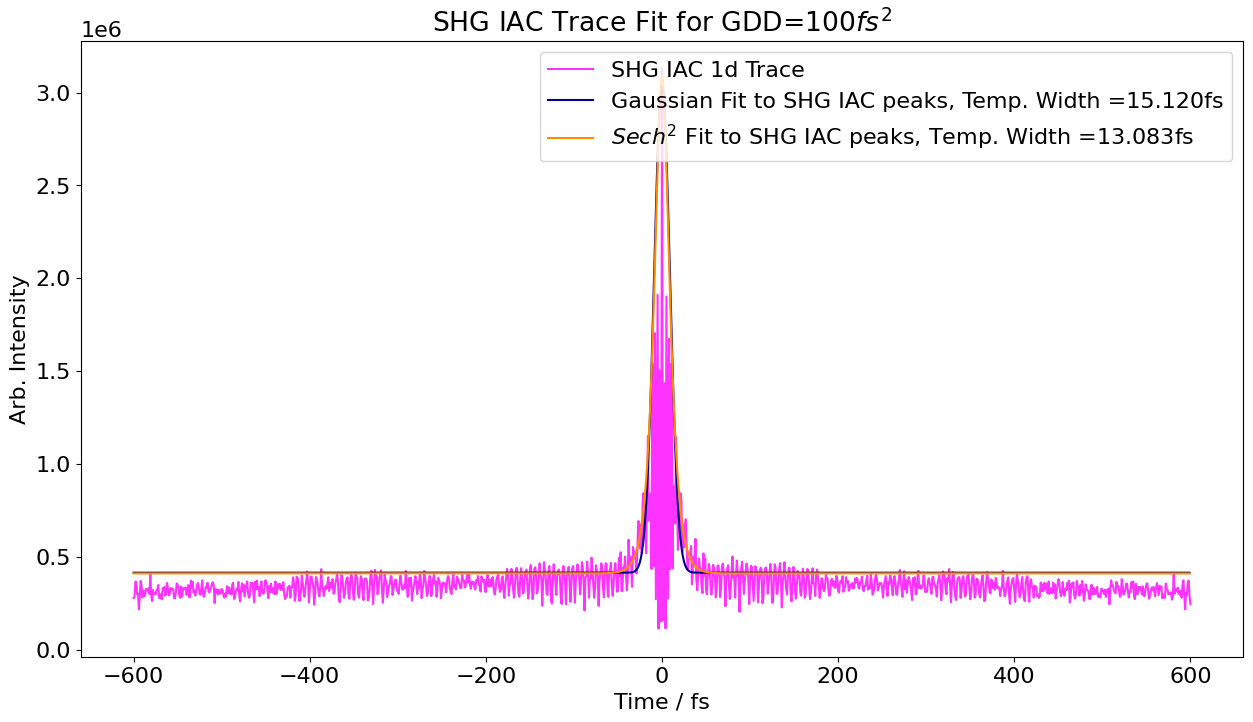

I am computing file 081225_GDD_750_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 165.244fs


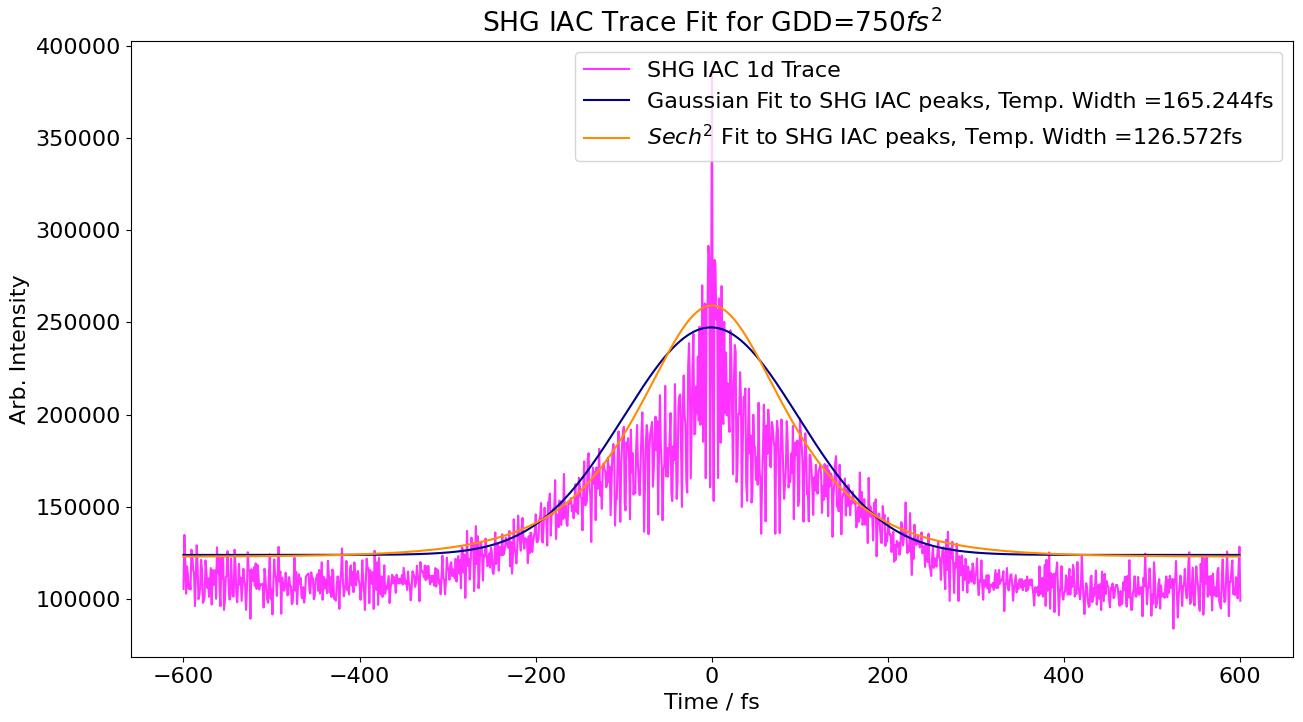

I am computing file 081225_GDD_600_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 136.888fs


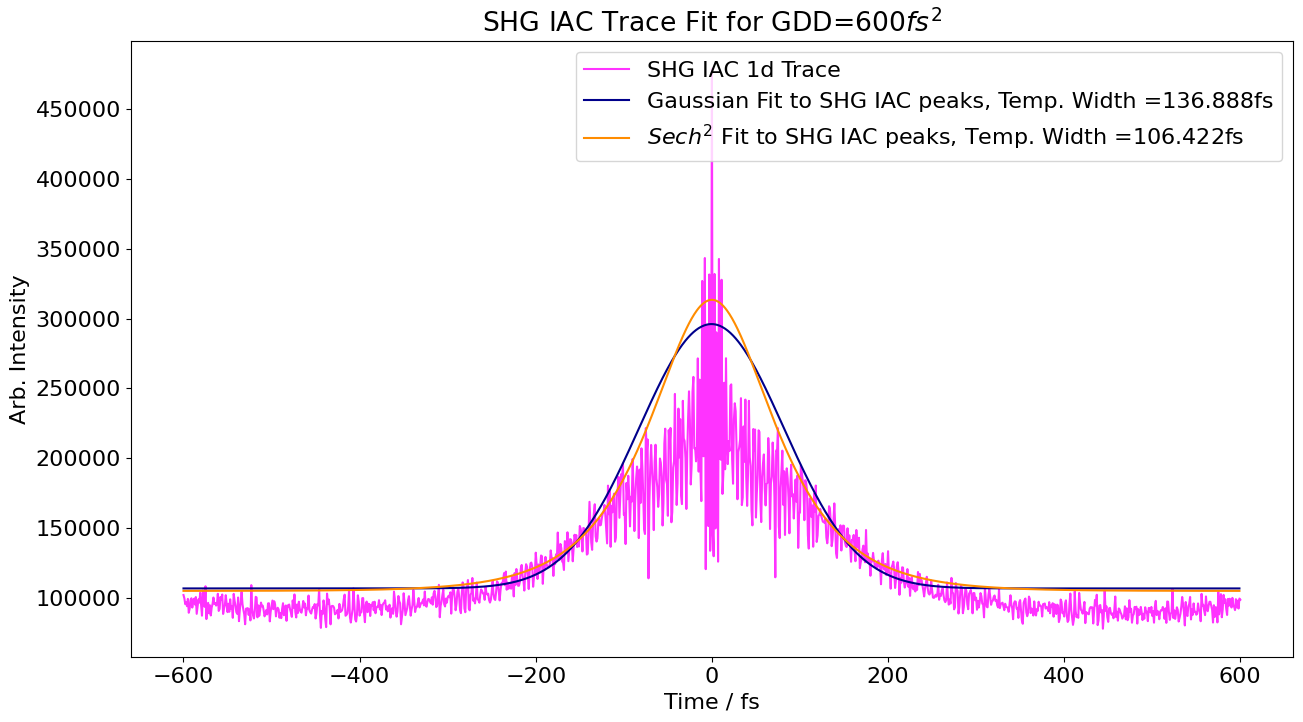

I am computing file 081225_GDD_900_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 181.335fs


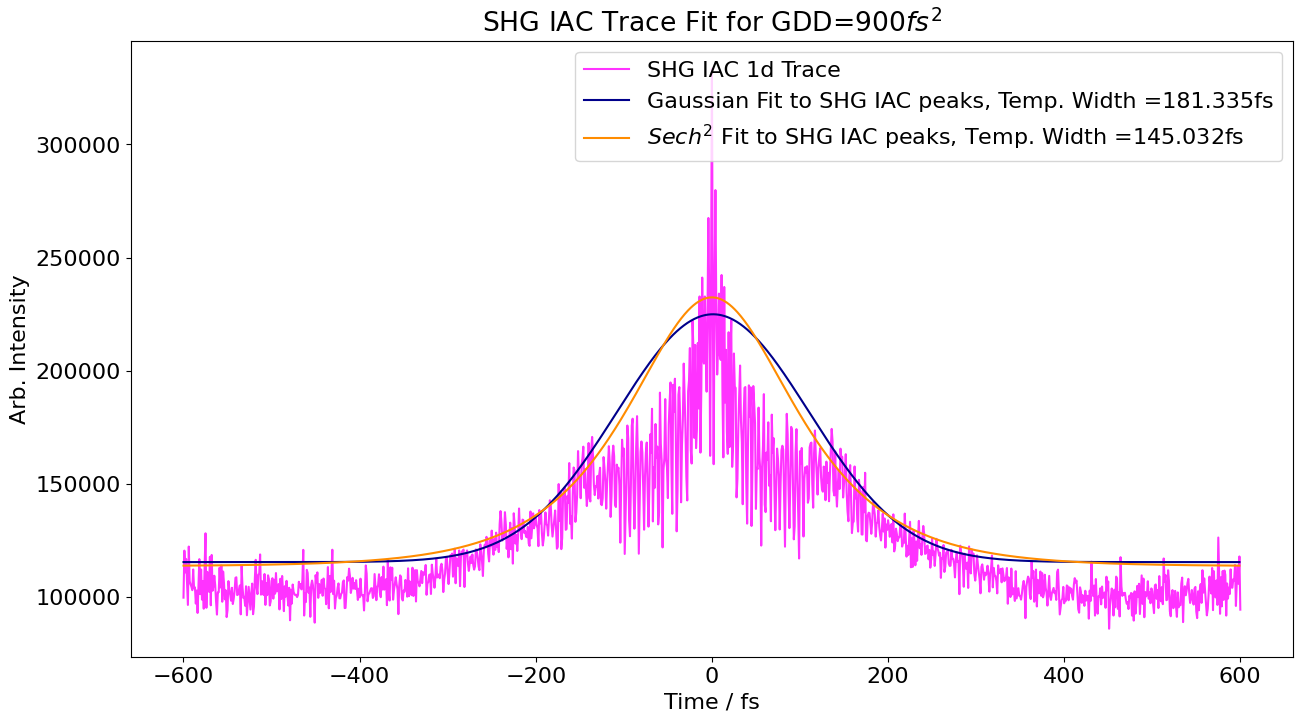

I am computing file 081225_GDD_850_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 182.787fs


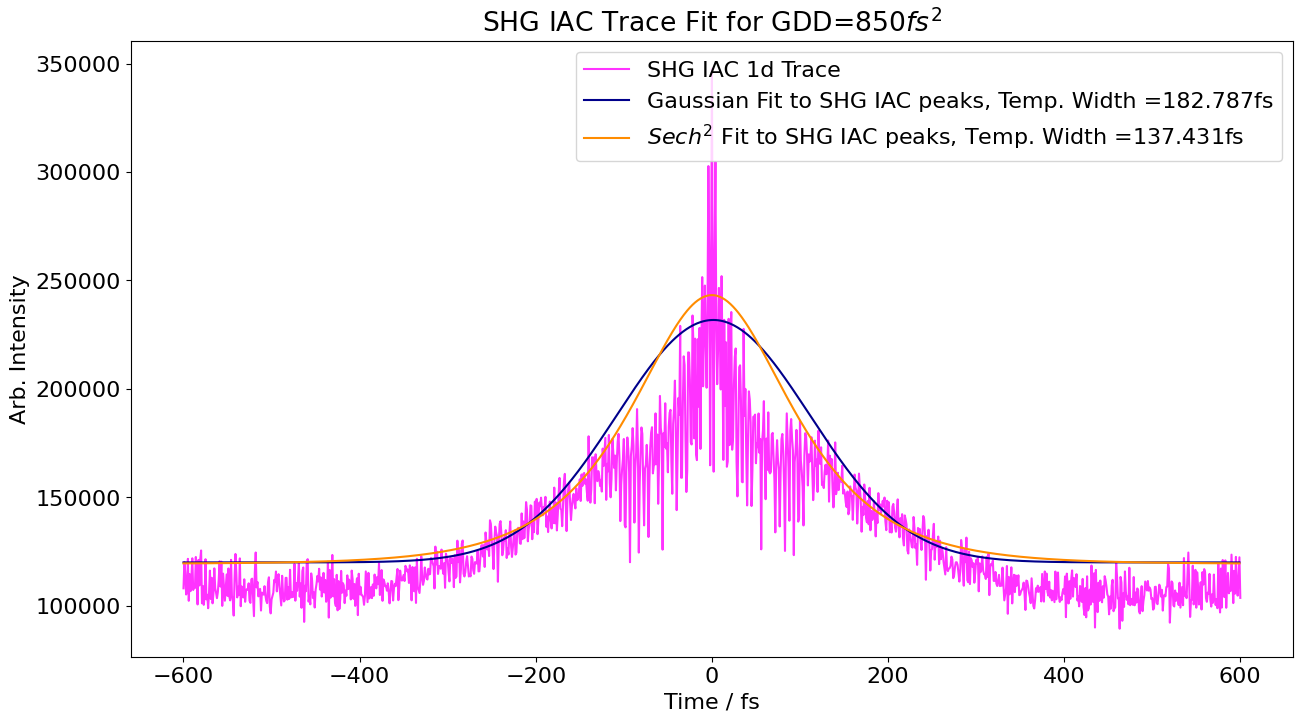

I am computing file 081225_GDD_1000_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 201.335fs


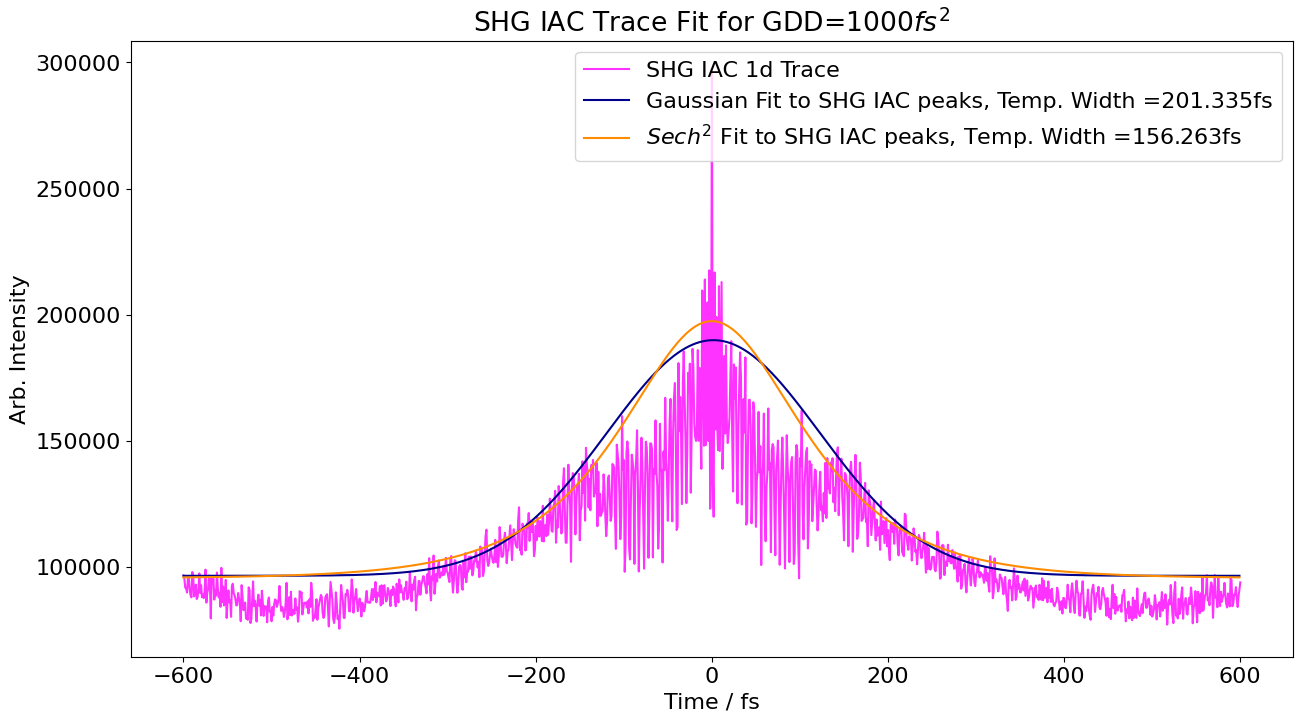

I am computing file 081225_GDD_650_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 149.841fs


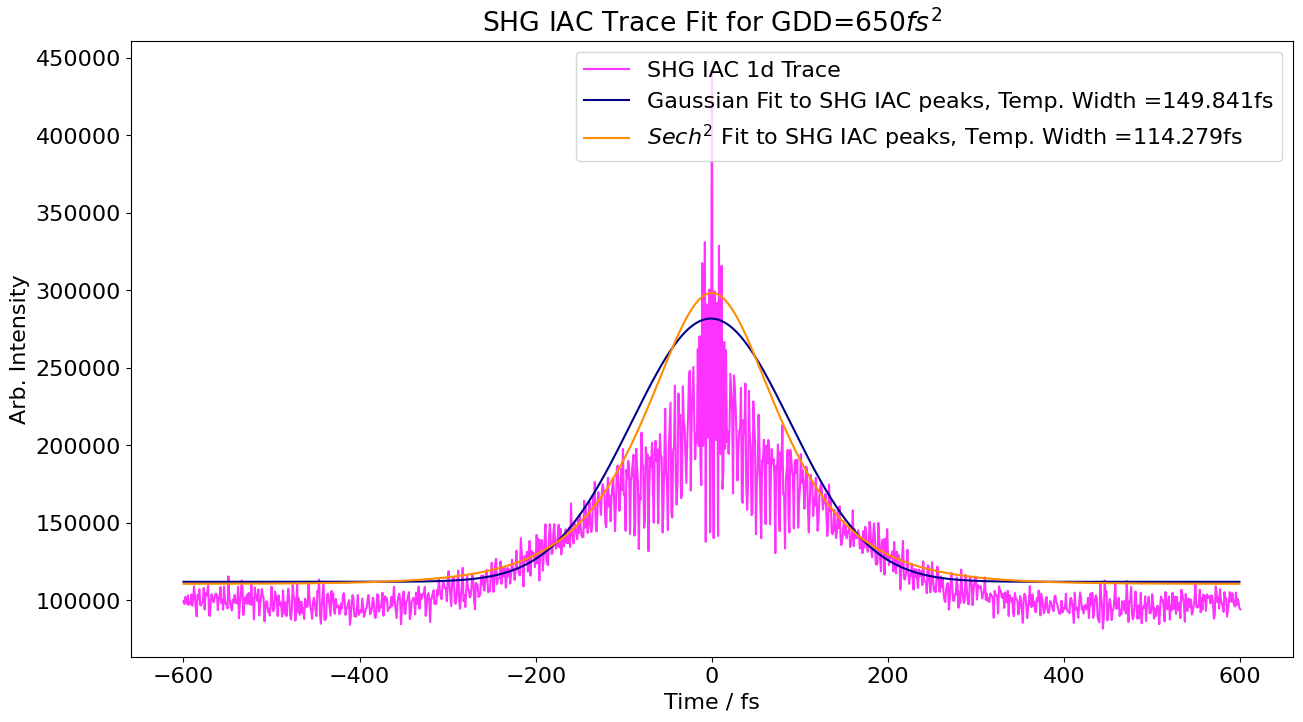

I am computing file 081225_GDD_700_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 159.627fs


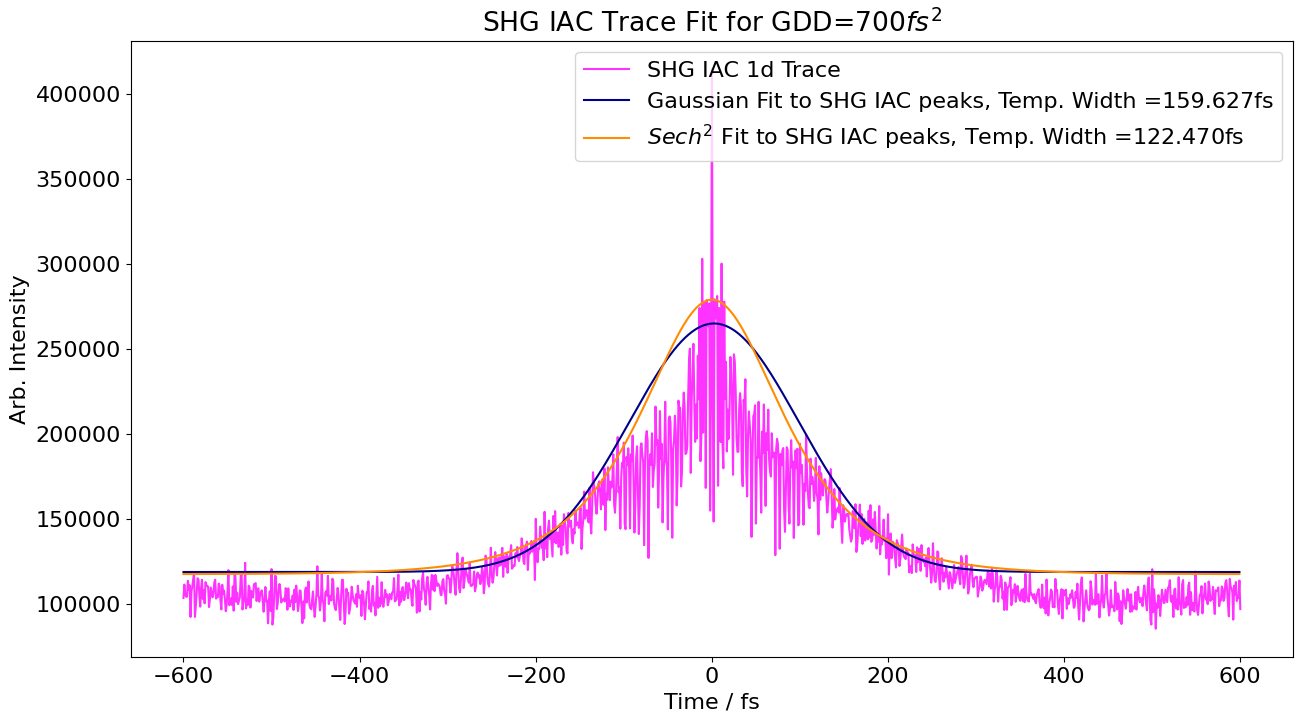

I am computing file 081225_GDD_800_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 164.961fs


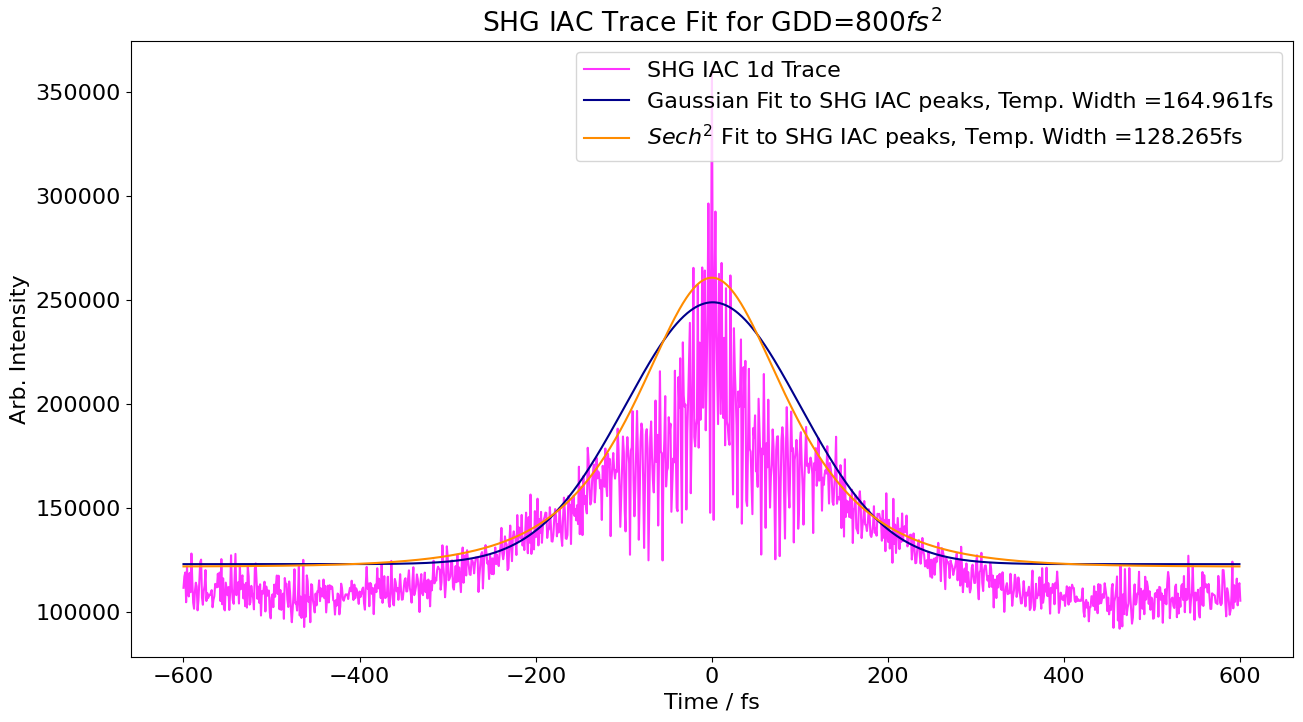

I am computing file 081225_GDD_950_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 169.211fs


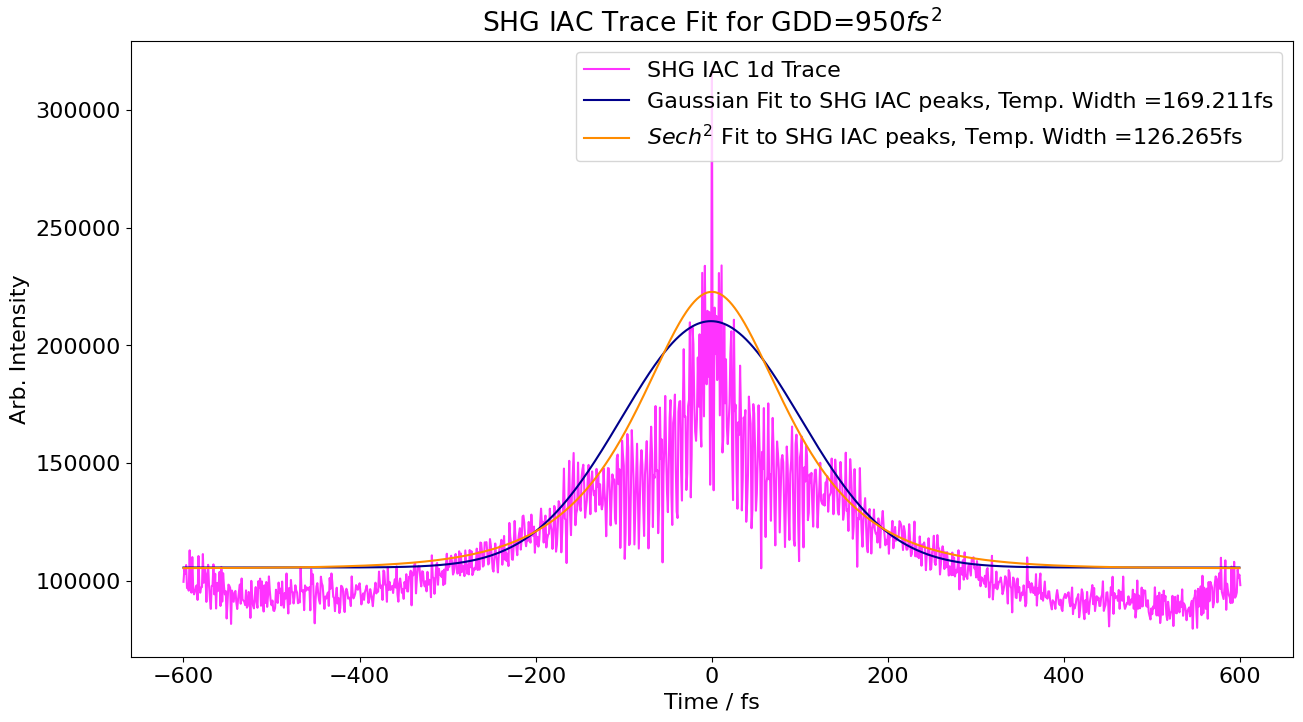

I am computing file 081225_GDD_150_1201_1_1d.txt
600
The estimated TL temporal width based on the above manipulation is 28.250fs


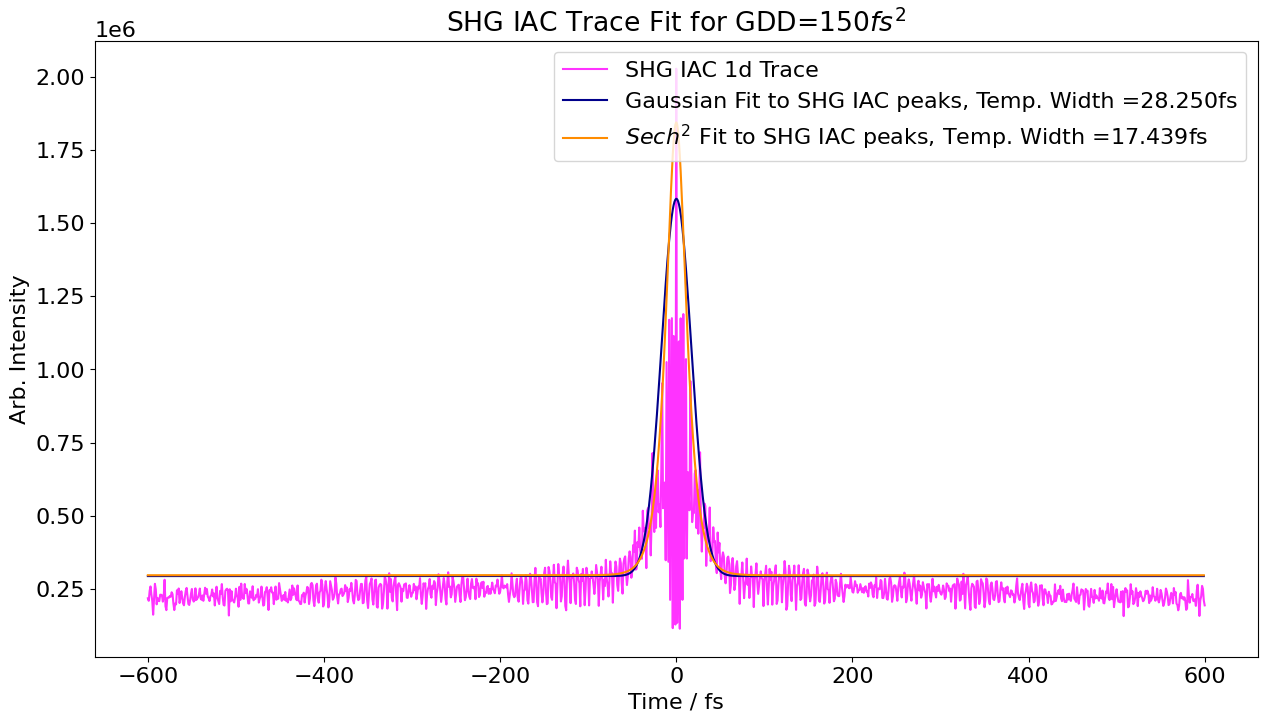

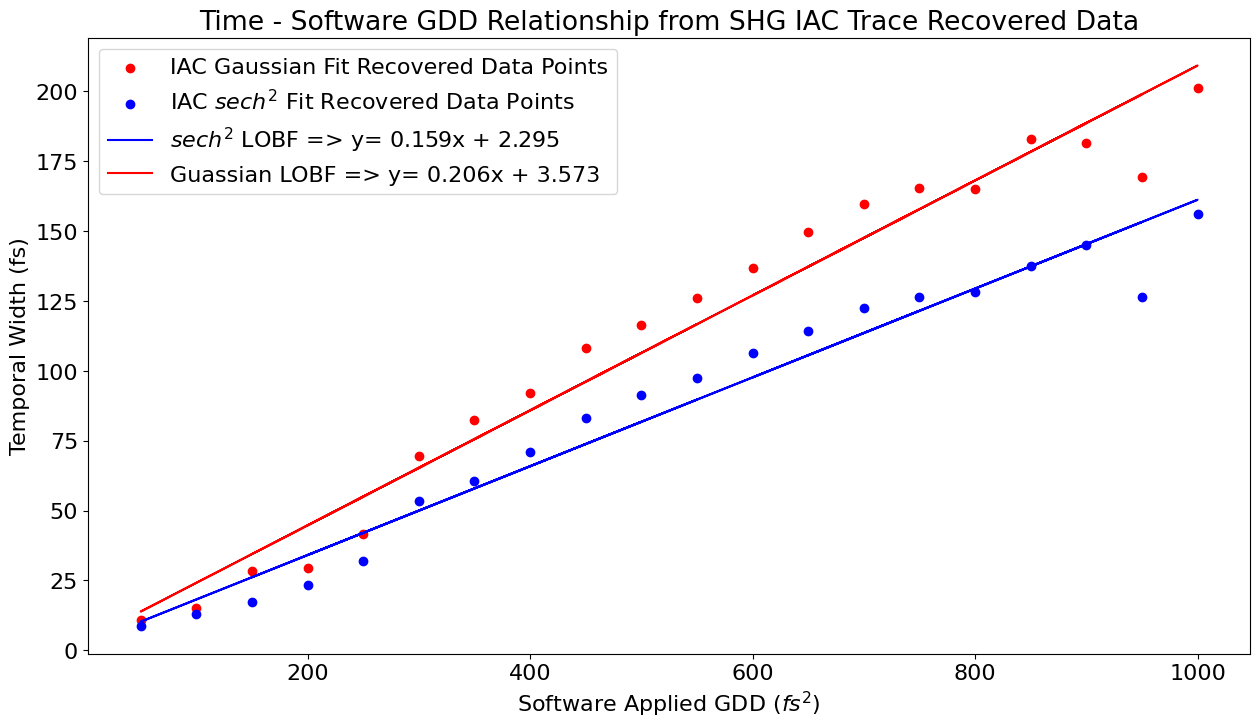

[ 450  500  350  200  250  300  550  400   50  100  750  600  900  850
 1000  650  700  800  950  150]
[ 450  500  350  200  250  300  550  400   50  100  750  600  900  850
 1000  650  700  800  950  150]
Gaussian [np.float64(108.2822851906708), np.float64(116.45760990241834), np.float64(82.22806285699869), np.float64(29.31053443971148), np.float64(41.51553708696656), np.float64(69.5340816321369), np.float64(126.1467199778629), np.float64(92.0290804091288), np.float64(10.813230852696053), np.float64(15.119878315512898), np.float64(165.24436907594188), np.float64(136.8884170514501), np.float64(181.33548492712595), np.float64(182.78722650297576), np.float64(201.33509924951676), np.float64(149.8405881235847), np.float64(159.6266322046599), np.float64(164.96079711236402), np.float64(169.21085587455596), np.float64(28.250250927779437)]
sech [np.float64(83.06993309262926), np.float64(91.34084559100543), np.float64(60.4549002864667), np.float64(23.276444781505532), np.float64(31.929205371373

In [24]:
day_three_folder =r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/081225/1d/'
day_three_save = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/Results/081225/'


FROG_trace_folder(day_three_folder,day_three_save, Relationship= True)

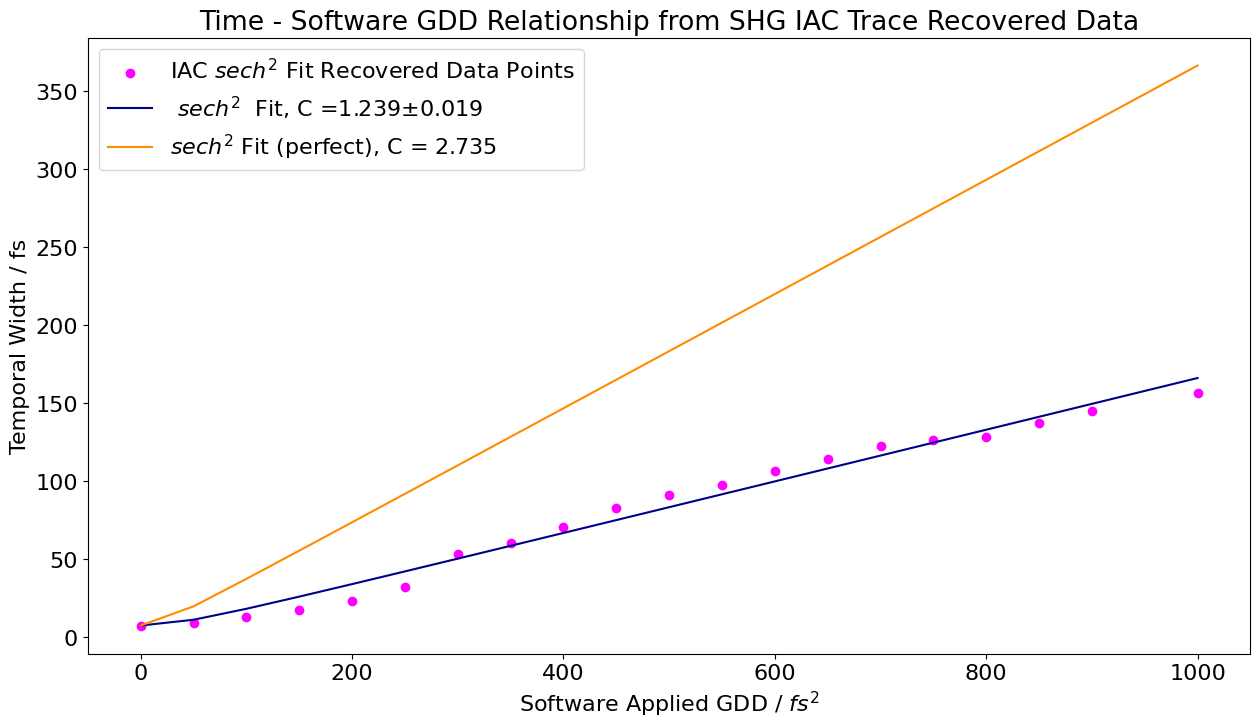

[0.00510512 2.85898207]
[0.01872374]
8.855251986213363


In [21]:
sim_file = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/Results/simulated_GDD_time_real.txt'
load_sim = np.loadtxt(sim_file)
GDD_sim =load_sim[:,0]
time_sim = load_sim[:,1]


file_from_above_3 =r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/Results/081225/Time_GDD_Relationship_GDD_recovered__08_12_25.txt'
loaded = np.loadtxt(file_from_above_3)

GDDs = loaded[:,0]
temporal_widths_gauss = loaded[:,1]
temporal_widths_sech = loaded[:,2]

temporal_widths_sech = np.hstack((7.463,temporal_widths_sech))
temporal_widths_gauss = np.hstack((7.463,temporal_widths_gauss))
GDDs = np.hstack((0,GDDs))

GDDs = np.delete(GDDs,19)
temporal_widths_sech =np.delete(temporal_widths_sech,19)



start = 0
end = 20

idx = np.argsort(GDDs)
GDDs = GDDs[idx]
temporal_widths_sech =temporal_widths_sech[idx]
temporal_widths_gauss =temporal_widths_gauss[idx]


GDDs_crop = GDDs[start:end]
temporal_widths_sech_crop = temporal_widths_sech[start:end]
temporal_widths_gauss_crop = temporal_widths_gauss[start:end]

def sech_fit(x,c):
    return 7.463*np.sqrt(1+((c*x)/(7.463)**2)**2)

def sech_2(x,t_0,c):
    return t_0*np.sqrt(1+((c*x)/(t_0)**2)**2)


def fith_poly(x,a,b,c,d):
    return 7.463*np.sqrt(1+a*(x**2) + b*(x**3) + c*(x**4) + d*(x**5) )

def exp(x,a,b,c,):
    return a * np.exp(b*x) + c 

params, params_covariance = curve_fit(linear_func, GDDs_crop, temporal_widths_sech_crop, p0=[1,0],maxfev =1000)
params2,params_covariance_2 = curve_fit(quad_func,GDDs_crop, temporal_widths_sech_crop, p0=[1,0,0])
params3,params_covariance_3 = curve_fit(fith_poly,GDDs_crop, temporal_widths_sech_crop, p0=[1e-7,1e-9,1e-11,1e-13], maxfev =1000)
params4,params_covariance_4 = curve_fit(sech_fit,GDDs_crop, temporal_widths_sech_crop, p0=[1.5])
params5,params_covariance_5 = curve_fit(sech_fit,GDDs_crop, temporal_widths_gauss_crop, p0=[1.5])
params6,params_covariance_6= curve_fit(sech_2,GDDs_crop, temporal_widths_gauss_crop, p0=[1.5,0])
params7,params_covariance_7= curve_fit(exp,GDDs_crop, temporal_widths_sech_crop, p0=[1e-5,1e-3,0], maxfev =2000)
params8, params_covariance8 = curve_fit(linear_func, GDD_sim, time_sim, p0=[1,0],maxfev =1000)
params9,params_covariance_9 = curve_fit(sech_fit,GDD_sim, time_sim, p0=[1.5])

plt.figure(figsize=(15,8))
#plt.scatter(GDDs, temporal_widths_gauss, color ='red', label = 'IAC Gaussian Fit Recovered Data Points')
plt.scatter(GDDs, temporal_widths_sech, color ='magenta', label = 'IAC $sech^2$ Fit Recovered Data Points')

#plt.scatter(GDD_sim, time_sim, color ='orange', label = 'Simulated Data')

#plt.plot(GDDs_crop,linear_func(GDDs_crop, params[0], params[1]), color ='darkblue', label = '$sech^2$ Straight Line => y= {0:.3f}±{1:.3f}GDD + {2:.3f}±{3:.3f}'.format(params[0],(np.sqrt(np.diag(params_covariance)))[0],params[1],(np.sqrt(np.diag(params_covariance)))[1]))
#plt.plot(GDD_sim,linear_func(GDD_sim, params8[0], params8[1]), color ='orange', label = '$sech^2$ Prediction Straight Line => y= {0:.3f}±{1:.3f}GDD + {2:.3f}±{3:.3f}'.format(params8[0],(np.sqrt(np.diag(params_covariance8)))[0],params8[1],(np.sqrt(np.diag(params_covariance8)))[1]))
#plt.plot(GDDs_crop,quad_func(GDDs_crop,*params2), color ='green', label ='Quadratic LOBF')
#plt.plot(GDDs_crop,fith_poly(GDDs_crop,*params3), color ='coral', label ='5th Order LOBF')
plt.plot(GDDs_crop,sech_fit(GDDs_crop,params4[0]), color ='darkblue', label =' $sech^2$  Fit, C ={0:.3f}±{1:.3f}'.format(params4[0],(np.sqrt(np.diag(params_covariance_4)))[0]))
#plt.plot(GDDs_crop,sech_fit(GDDs_crop,params5[0]), color ='red', label ='Guassian Fit, C ={0:.3f}'.format(params5[0]))
plt.plot(GDDs_crop,sech_fit(GDDs_crop,2.735), color ='darkorange', label ='$sech^2$ Fit (perfect), C = 2.735')
#plt.plot(GDDs_crop,sech_fit(GDDs_crop,2.241), color ='magenta', label ='Broadening Predicted, C = 2.241')
#plt.plot(GDD_sim,sech_fit(GDD_sim,*params9), color ='brown', label ='$sech^2$ Prediction Literature Fit, C ={0:.3f}±{1:.3f}'.format(params9[0],(np.sqrt(np.diag(params_covariance_9)))[0]))
#plt.plot(GDDs_crop,sech_2(GDDs_crop,params6[0],params6[1]), color ='red', label ='Broadening Predicted, C = {0:.3f}, t_0 ={1:.3f}'.format(params6[1],params6[0]))
#plt.plot(GDDs_crop,sech_fit(GDDs_crop,(4*np.log(2))), color ='green', label ='Gaussian Fit (perfect), C = 4ln(2))')
plt.xlabel("Software Applied GDD / $fs^2$")
plt.ylabel("Temporal Width / fs")
#plt.axvline(550)
#plt.ylim(-10,100)
plt.title("Time - Software GDD Relationship from SHG IAC Trace Recovered Data")
title = 'Time_GDD_Relationship_GDD_recovered_'+(date.today()).strftime("_%d_%m_%y")+'.png'
save_folder =os.path.join(day_three_save,title)
plt.legend()
plt.savefig(save_folder)

plt.show()

straight_error = np.sqrt(np.diag(params_covariance))
print(straight_error)
set_sech_error = np.sqrt(np.diag(params_covariance_9))
print(set_sech_error)

print(temporal_widths_sech[1])

The estimated TL temporal width based on the above manipulation is 25.595fs


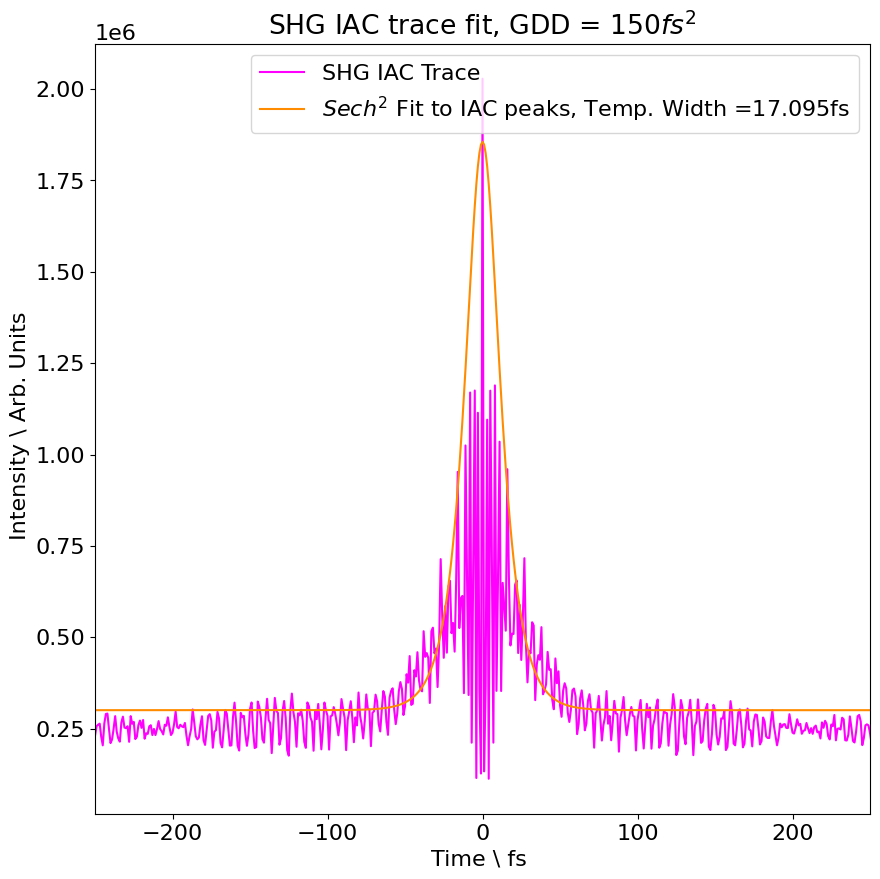

In [36]:
file_path =r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/081225/1d/081225_GDD_150_1201_1_1d.txt'


applied_GDD =150

FWHM_time = FROG_trace(file_path, applied_GDD)

I am computing file T_mask_pulse_width_251_pixels_75nm_1d.txt
400
The estimated TL temporal width based on the above manipulation is 14.800fs


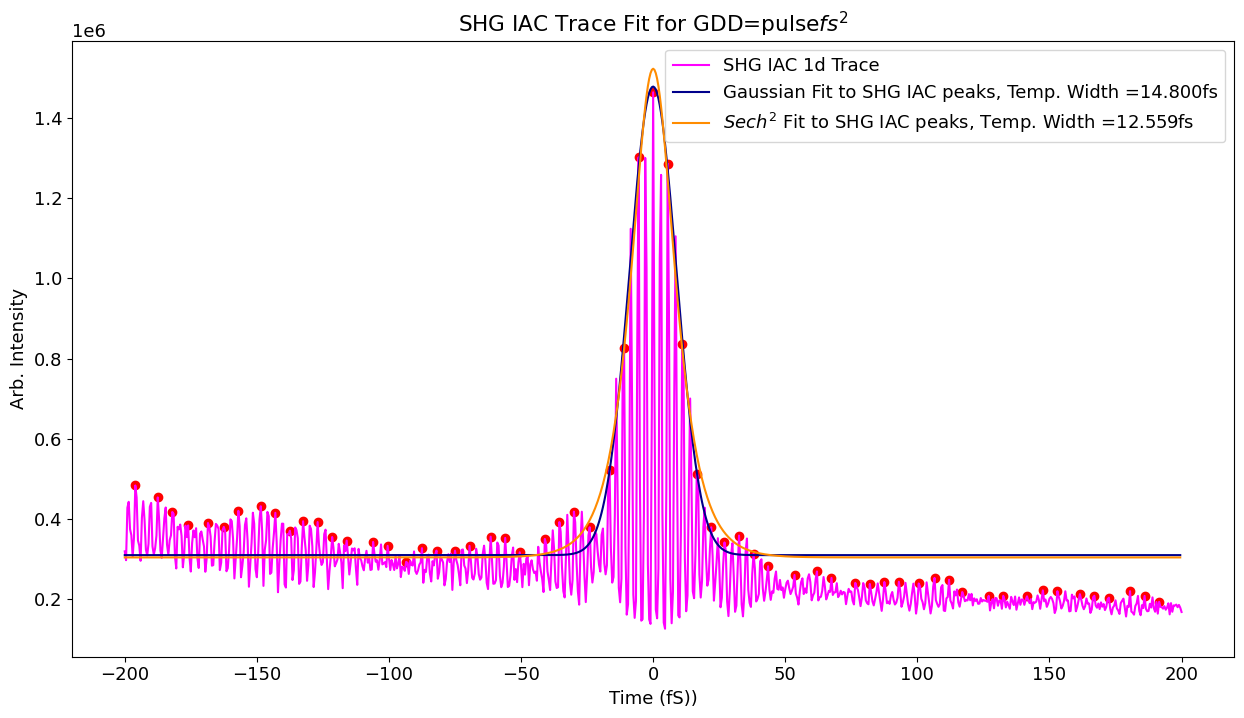

I am computing file T_mask_pulse_width_168_pixels_50nm_1d.txt
400
The estimated TL temporal width based on the above manipulation is 24.056fs


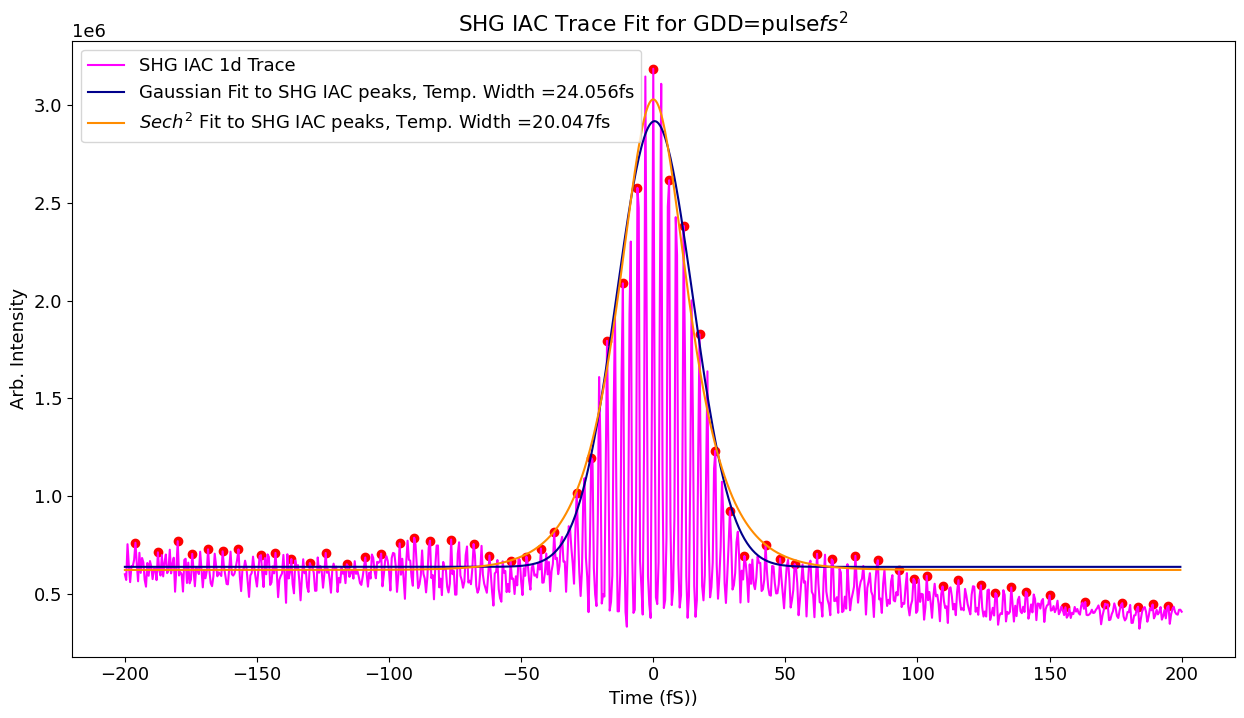

I am computing file T_mask_pulse_width_33_pixels_10nm_1d.txt
400
The estimated TL temporal width based on the above manipulation is 83.818fs


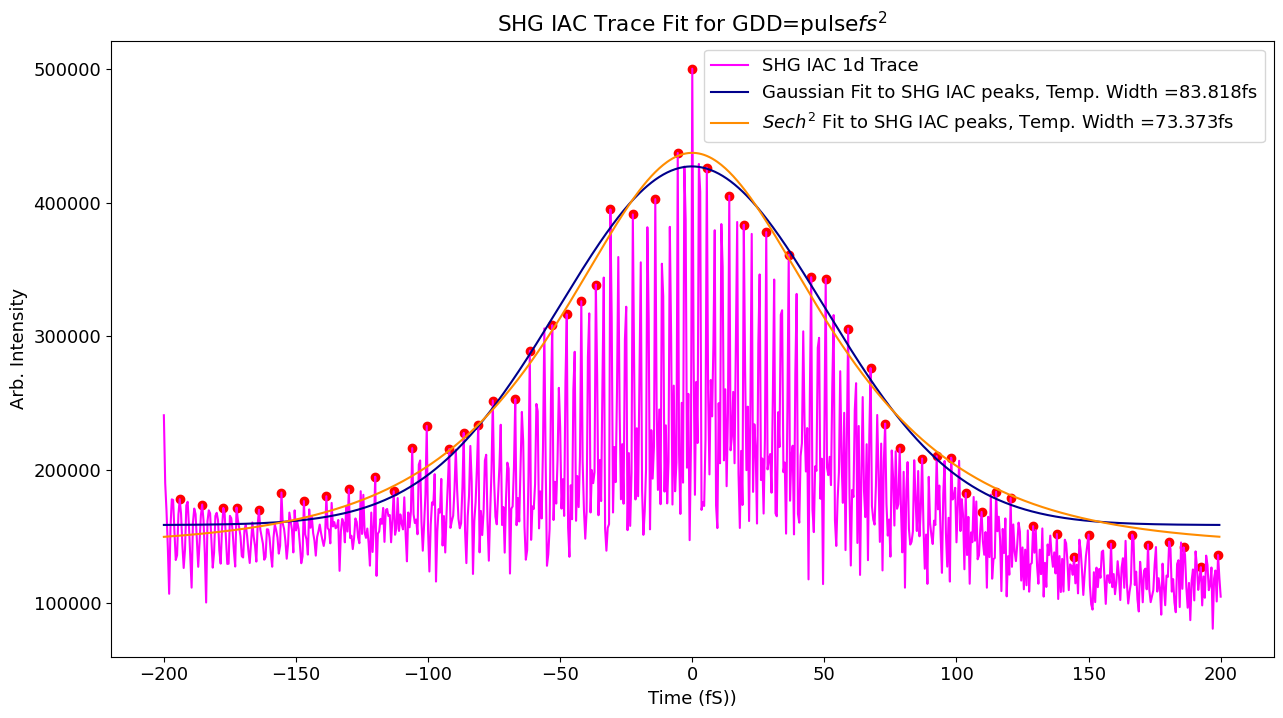

I am computing file T_mask_pulse_width_335_pixels_100nm_1d.txt
400
The estimated TL temporal width based on the above manipulation is 14.454fs


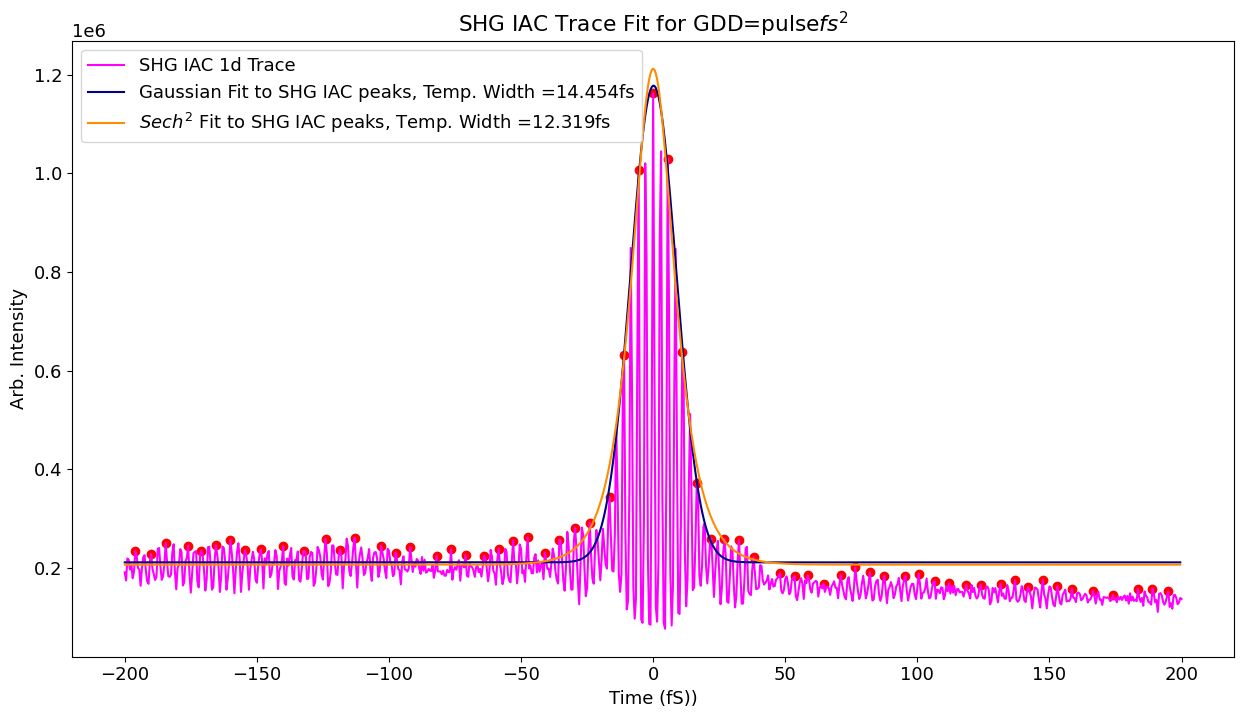

['pulse', 'pulse', 'pulse', 'pulse']
['pulse', 'pulse', 'pulse', 'pulse']
Gaussian [np.float64(14.800103702010164), np.float64(24.056314333194166), np.float64(83.81847631816406), np.float64(14.45365167606946)]
sech [np.float64(12.558880808010944), np.float64(20.04668201310185), np.float64(73.37273340744245), np.float64(12.318668238749146)]


In [30]:
trans_masks_folder =r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/200126/traces2/'
trans_masks_save = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/200126/IAC Output/'


FROG_trace_folder(trans_masks_folder,trans_masks_save, Relationship= False)

In [17]:
#trans_masks_gaussian_folder =r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/200126/Gaussian IAC 2/'
#trans_masks_gaussian_save = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/200126/Gaussian IAC Output/'


#FROG_trace_folder(trans_masks_gaussian_folder,trans_masks_gaussian_save, Relationship= False)

I am computing file trans_mask_10_nm_gaussian_1000_GDD_2_1d.txt
400
The estimated TL temporal width based on the above manipulation is 119.087fs


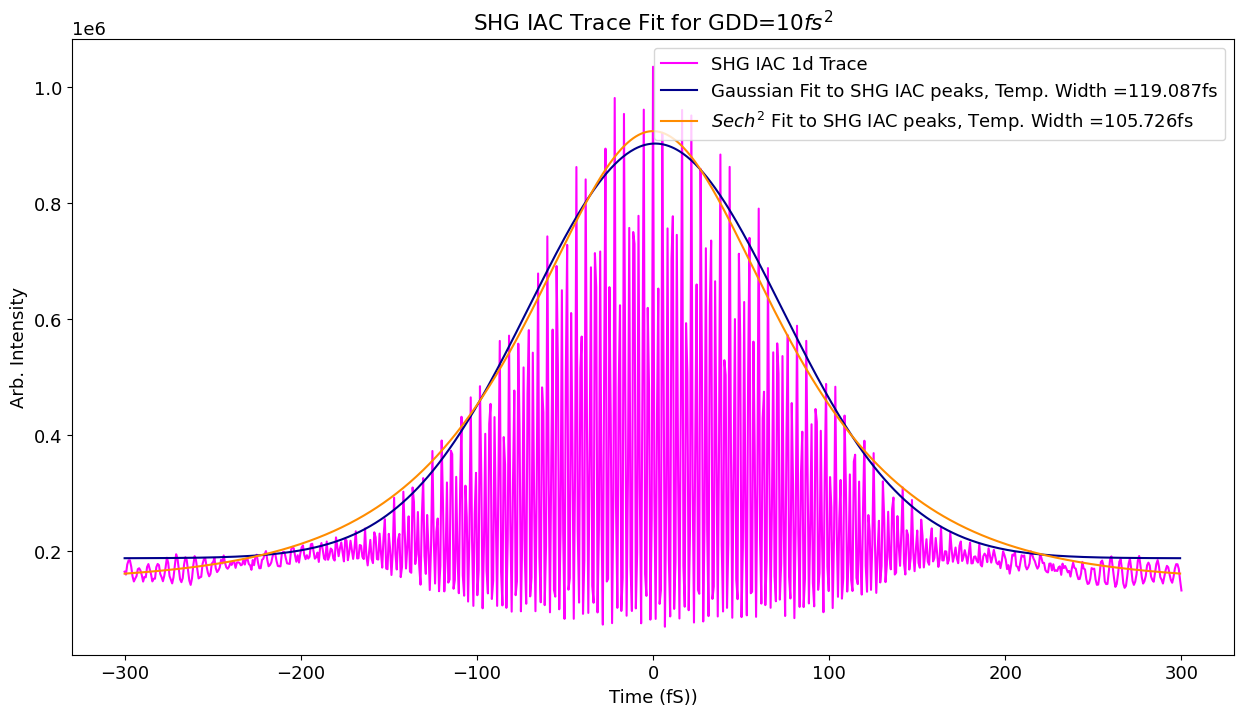

I am computing file trans_mask_10_nm_gaussian_150_GDD_1d.txt
400
The estimated TL temporal width based on the above manipulation is 95.942fs


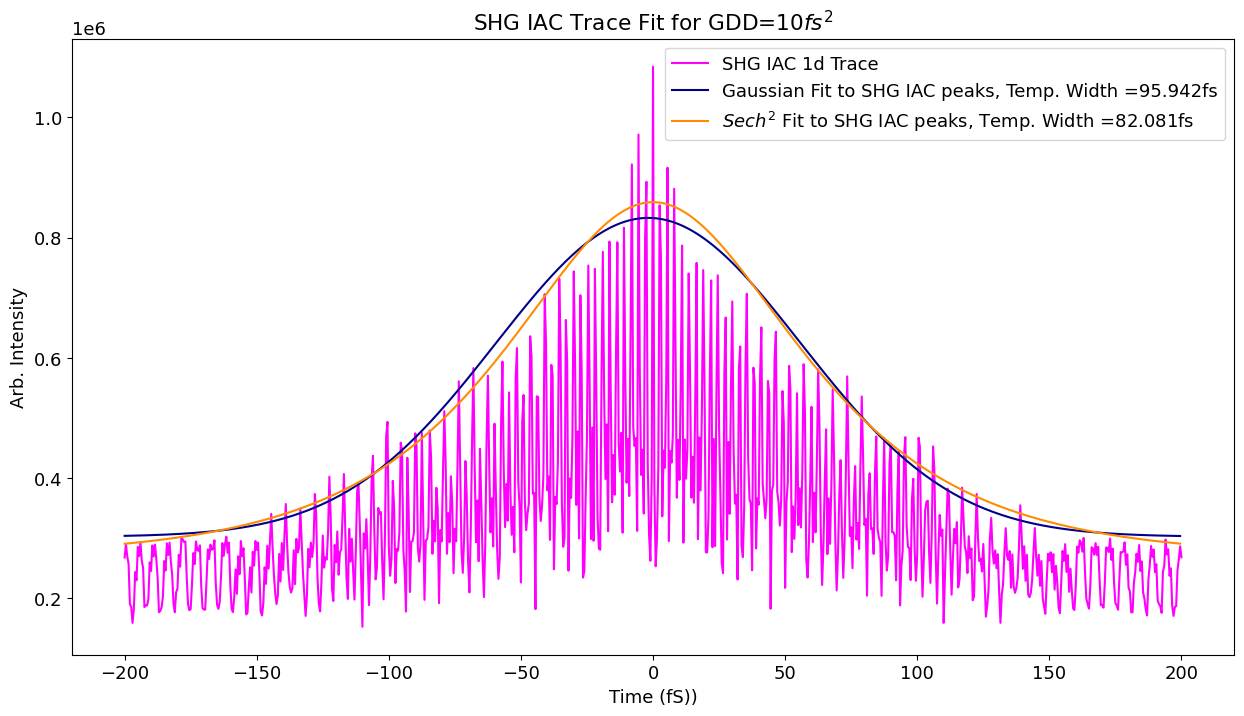

I am computing file trans_mask_10_nm_gaussian_1000_GDD_1d.txt
400
The estimated TL temporal width based on the above manipulation is 112.036fs


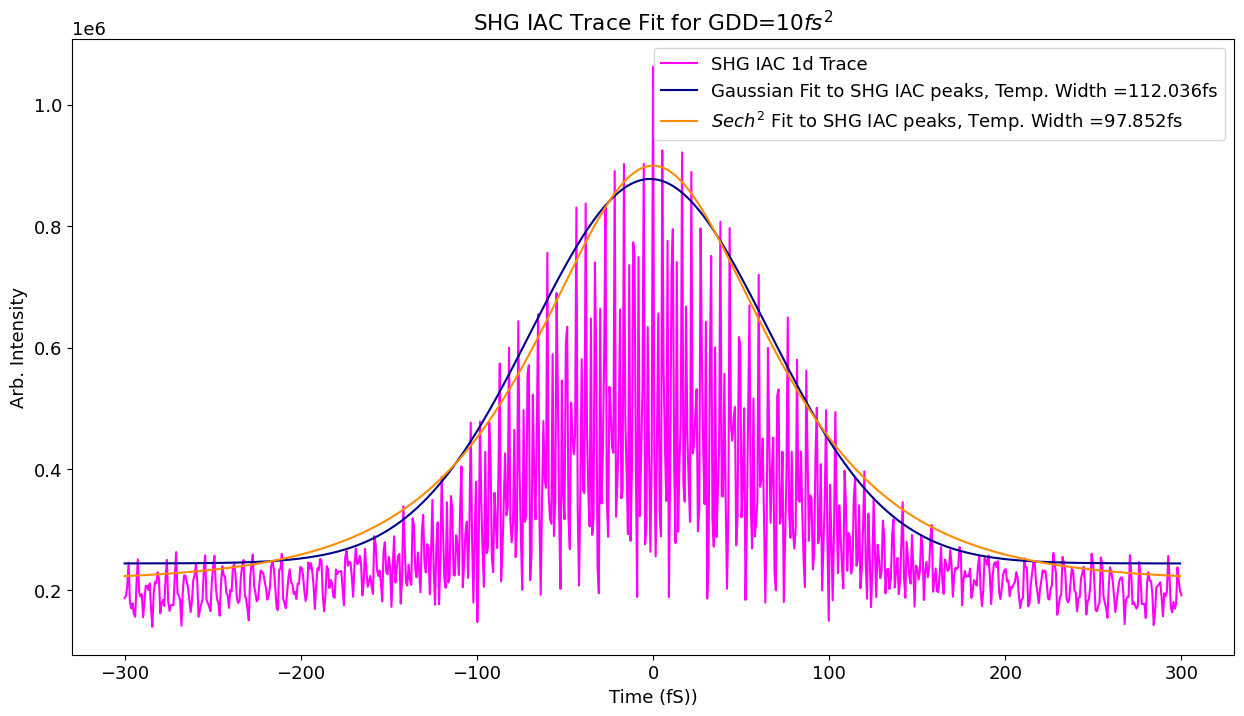

[10, 10, 10]
[10, 10, 10]
Gaussian [np.float64(119.08719410955834), np.float64(95.94190047828988), np.float64(112.03635687666551)]
sech [np.float64(105.72589047834487), np.float64(82.08137535038016), np.float64(97.85184789716186)]


In [5]:
trans_masks_gaussian_folder_2 =r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/200126/Guass Broad/'
trans_masks_gaussian_save = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/200126/Gaussian IAC Output/'


FROG_trace_folder(trans_masks_gaussian_folder_2,trans_masks_gaussian_save, Relationship= False)

I am computing file trans_mask_10nm_gaussian_6000_GDD_1d.txt
400
The estimated TL temporal width based on the above manipulation is 147.524fs


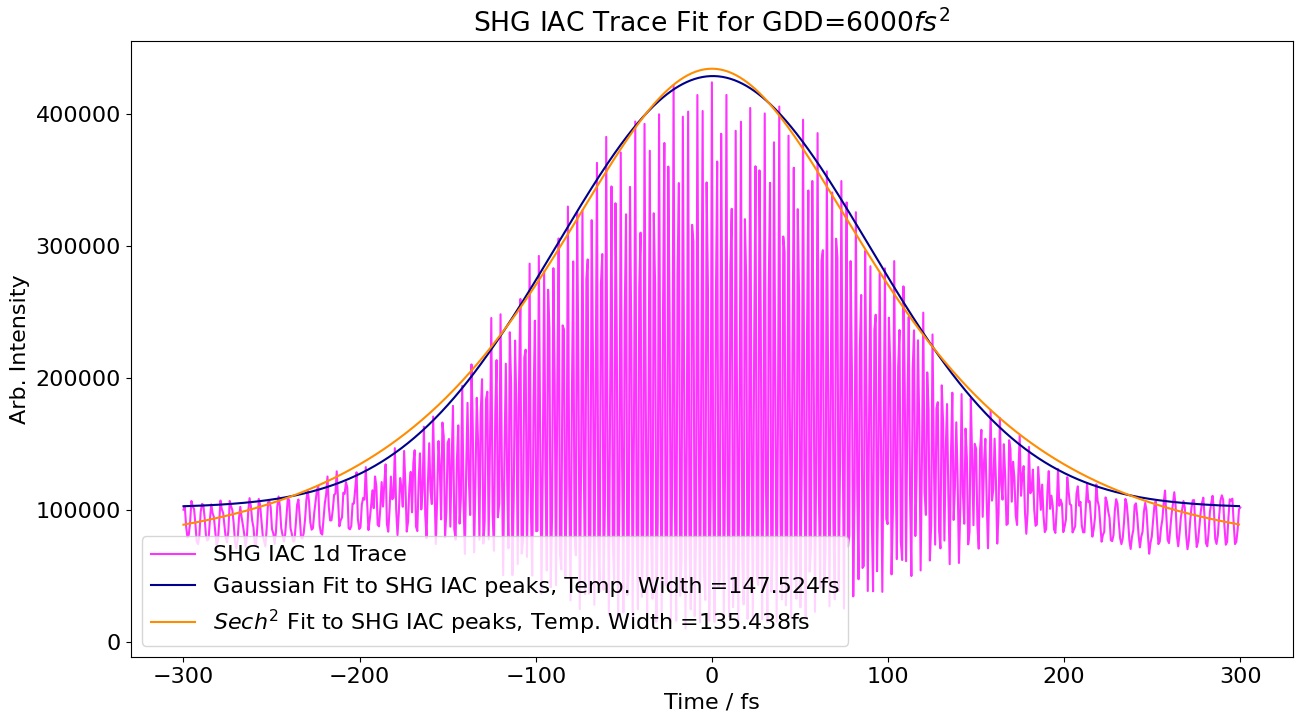

I am computing file trans_mask_10nm_gaussian_5000_GDD_1d.txt
400
The estimated TL temporal width based on the above manipulation is 138.823fs


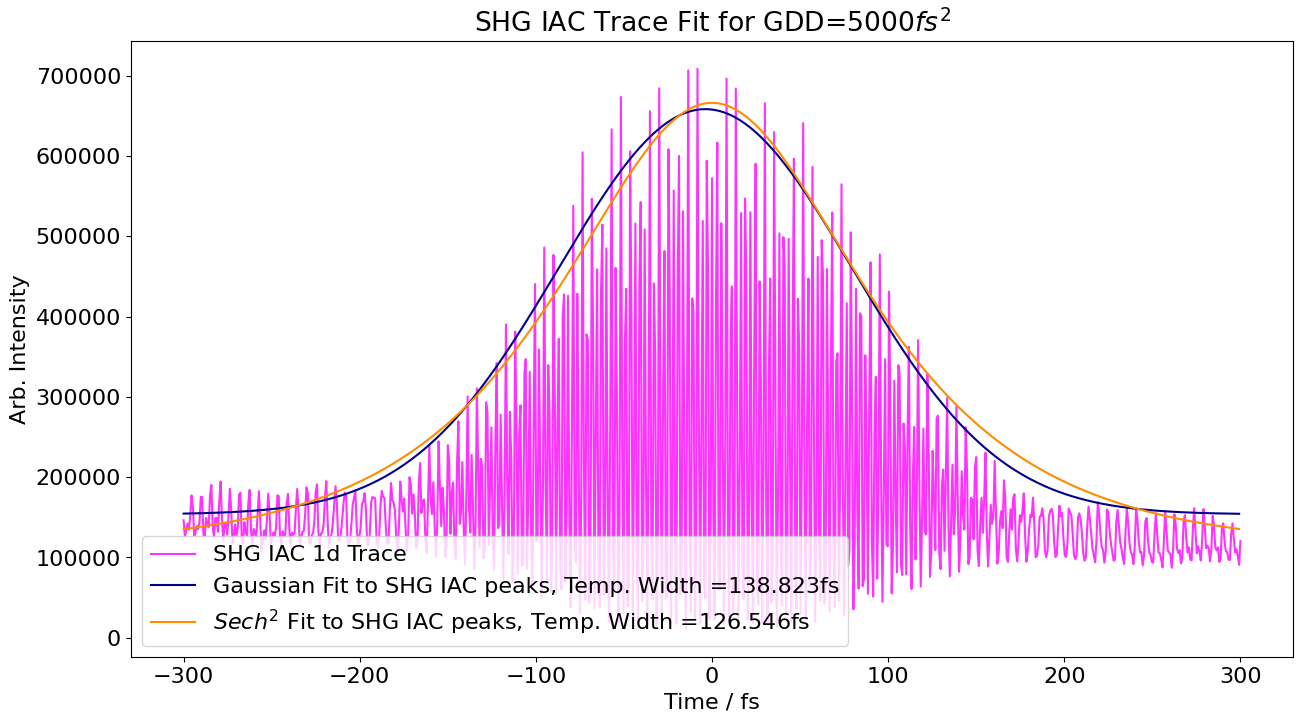

I am computing file trans_mask_10nm_gaussian_5500_GDD_1d.txt
400
The estimated TL temporal width based on the above manipulation is 143.406fs


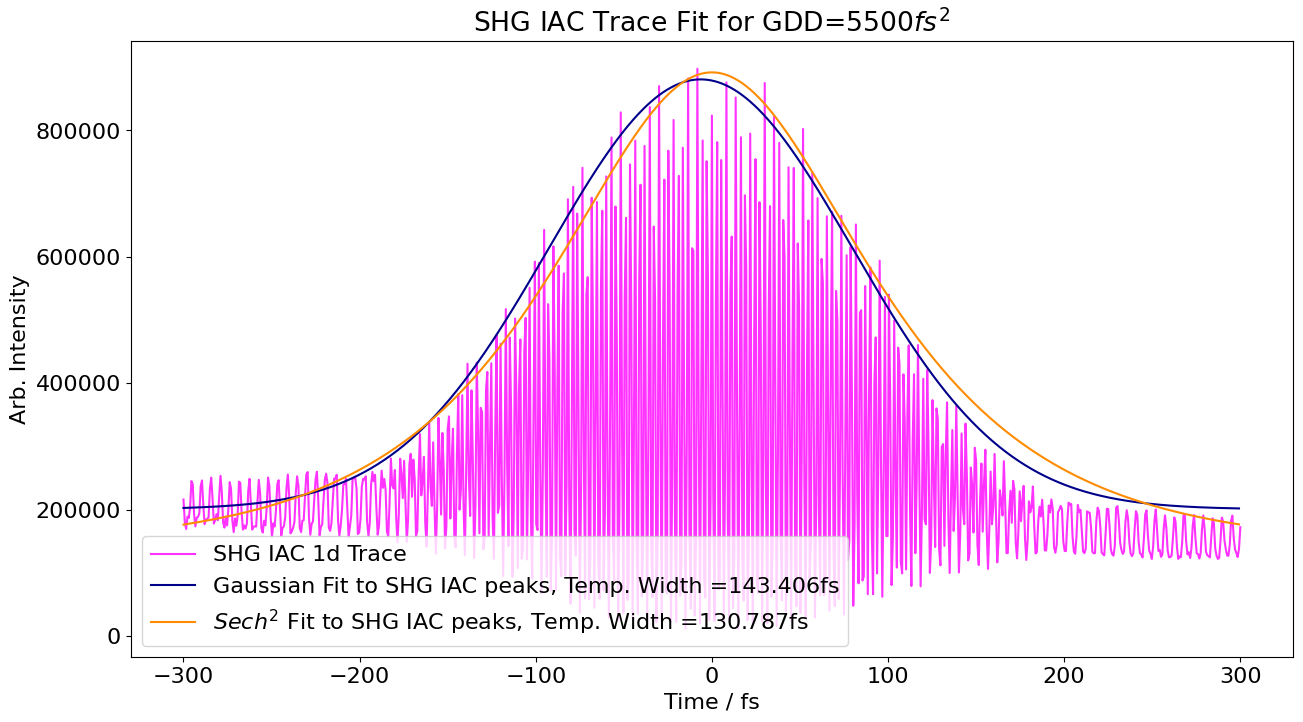

I am computing file trans_mask_10nm_gaussian_5250_GDD_1d.txt
400
The estimated TL temporal width based on the above manipulation is 140.906fs


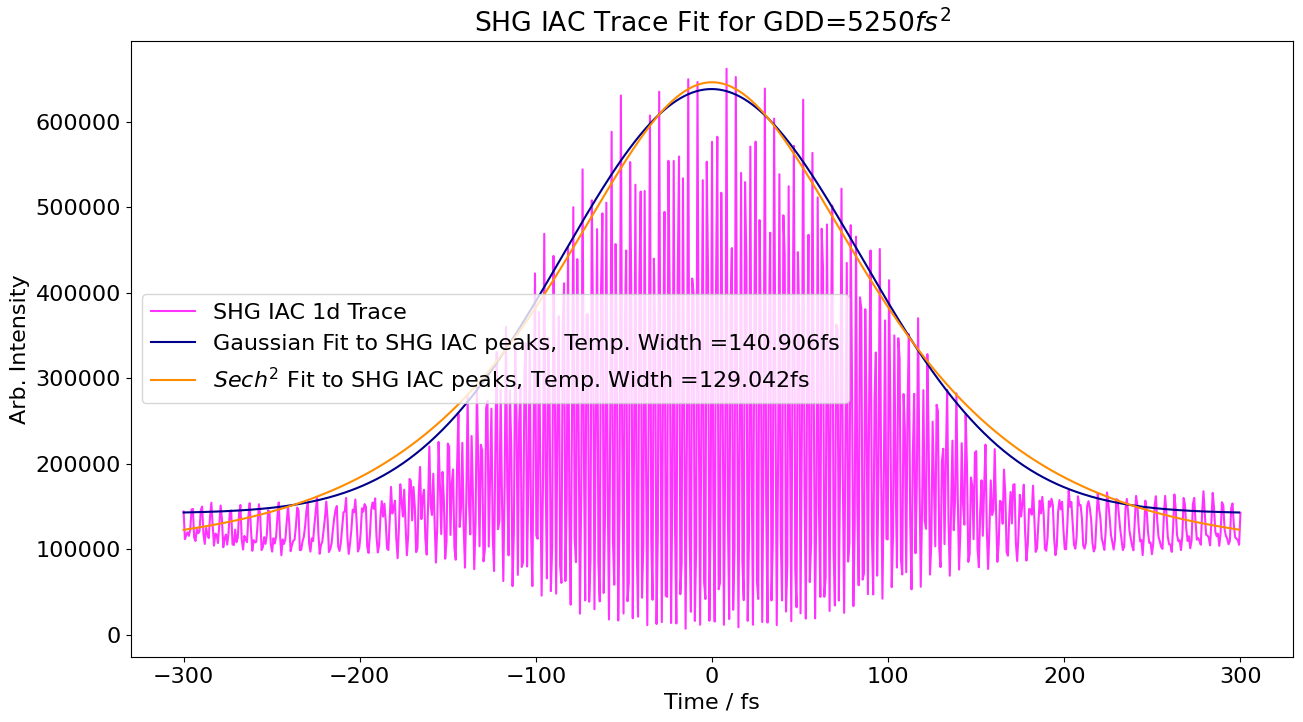

I am computing file trans_mask_10nm_gaussian_3000_GDD_1d.txt
400
The estimated TL temporal width based on the above manipulation is 121.816fs


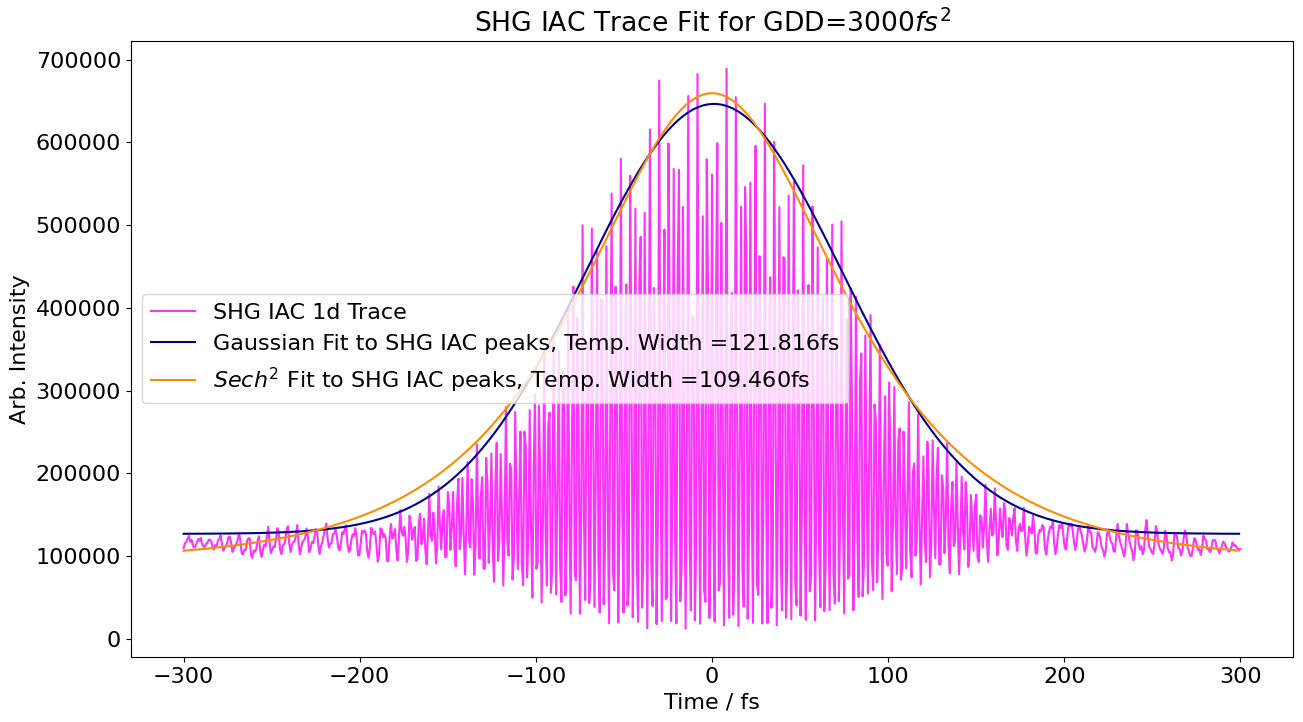

[6000, 5000, 5500, 5250, 3000]
[6000, 5000, 5500, 5250, 3000]
Gaussian [np.float64(147.52449069202964), np.float64(138.8229360803473), np.float64(143.40599556834266), np.float64(140.90608256447283), np.float64(121.81567006862271)]
sech [np.float64(135.4375681910712), np.float64(126.54558169325088), np.float64(130.78683643747775), np.float64(129.041784662894), np.float64(109.45960338035945)]


In [32]:
trans_masks_gaussian_folder_2 =r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/260126/IAC Output/IAC output 2/'
trans_masks_gaussian_save = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/260126/'


FROG_trace_folder(trans_masks_gaussian_folder_2,trans_masks_gaussian_save, Relationship= False)